### The building with SSI feature FEM updating using GA, L-BFGS-B, GP for optimization

#### In this code, the procedures are:
1. Building surrogate model for 1st, 2nd dominated frequencies (here using $f_{n,1}$ and $f_{n,2}$ to represent):
   - Using GP regression (GPR) to form the surrogate model. each GPR with 19 input will return the $f_{n,i}$. Therefore there are 6 GPRs will be generated corresponding to  $f_{n,1}$ and $f_{n,2}$ for 3 excitation case, i.e. ex22, ex220, ex221. 
2. Sensitivity analsys:
   - Using Sobol-indics to find out the significant parmaeter for GPR. (NOT the whole FRF, only focus on $f_{n,1}$ and $f_{n,2}$)
3. Using the GA to optimize the $f_{n,1}$ and $f_{n,2}$, fitting with exp data based on significant parameters:
   - Using GA to increase the reproducalbility, if using L_BFGS-B directly, it is also work, however, it will be very sensitive to initial guess. 
   - GA is sometime sensitive to initial guess also. Therefore we fix the non-significant parameter at 0.5 and randomly assign the initial significant parameter.
4. Using L-BFGS-B to fine-tuning the $f_{n,1}$ and $f_{n,2}$, fitting with exp data based on significant parameters:
   - The optimiazaiton result from GA is not precies, but with a good direction, therefore we use L-BFGS-B to fine-tuning for better result.
   - The usage of GA + L-BFGS-B only used for tuning the significant paramters and try to fit the $f_{n,1}$ and $f_{n,2}$ only but not the whole frequency series, therefore only the position of $f_{n,1}$ and $f_{n,2}$ are accurate. The reason why we only fit this two points but not the whole frequency series is because we are seeking the method that can update te FEM when only the OMA data are avaiable, without the exp FRFs. From the OMA analysis, we can only obtain the dominated frequcies, damping ratio, mode shapes. We tried to use such limited information for FEM update. In the following GP optimization process, It can be treated as the extentsion if we assumed the FRFs data are also collected.
5. Using GP optimizor to tuning the whole FRFs except the $f_{n,1}$ and $f_{n,2}$ , fitting with exp FRFs based on non-significant parameters:
   - The objective function is in following. We will use the result from GPRs, from FRFs to form the obj function.


#### Note 1
- Input the parameter sets from lhs_data.json
- Using bool_SSI to design whether require SSI features, if false, then SSI will be turned off and the parameter: soil_para will have no effects
- Varying the parameters $X_{i}$ with the range in $R_{vary} \cdot X_{i} \cdot [ 0, 1]$, where $X_{i}$ is the current paramter and $R_{vary}$ is vary_ratio.
- The parameter sets of the building strucutre are [slab , corridor, ground, edge_wall, inner_wall, stair]
- Assumning the mean of parameter sets for thickness are [0.468, 0.8, 0.05, 0.2, 0.2, 0.468] (m)
- Assumning the mean of parameter sets for Young's modulus are [20e9, 20e9, 20e9, 20e9, 20e9, 20e9] (pa)
- Assumning the mean of parameter sets for possion's ratio are [0.27 0.27 0.27, 0.27, 0.27] (-)
- Assumning the mean of parameter sets for density are [2300, 2300, 2300, 2300, 2300] ($\frac{kg}{m^{3}}$)
- Assumning the mean of parameter sets for soil are [350, 1400, 0.33] w.r.t Shear wave velocity, density and possion's ratio.
- Assumning the mean of height of each floor is 3.37 (m)
- Assumning the mean of damping ratio is 0.045 (-)
  
#### Note 2
- Once the DOE results are generated and stored in designated path, we can import them from the path and do further analysis.
- DON'T NEED TO RUN THE 1000 SIMULATION EVERY TIME, it will take over 10 hrs.
- There are three case, since we did three hammer testings based on different excitation location.
- The naminr rule is quite confusing since the data are collected from several sides, here is the simple instructions:
  - From the simulation: There are three excitaion event, naming: ex22, ex220, ex221, their excitation locations are marked in the report.
  - From the experiment, the data is stored in ```.mat``` file, which is stored in ```./DATA_GM_RawData/DATA_ACC_Measure12032024/DATA_Hammer/Time_domain_update```
    - The file naming with OG_2_2_0... corresponding to ex220, where are the first to 6th files from the top in the folder, therefore we used the var ```i_file``` = 1...6 to call them.
    - The file naming with OG_2_2_1... corresponding to ex221, where are the 7th to 9th files from the top in the folder, therefore we used the var ```i_file``` = 7...9 to call them.
    - The file naming with OG_2_2... corresponding to ex22, where are the 10th to 13th files from the top in the folder, therefore we used the var ```i_file``` = 10...13 to call them.
- In each experiment ```.mat``` file, there are 19 channels, where the 19th channel is the excitation signal and the CH 9,10,11,12 are the sensors at 1OG and the CH 3,13,14,15 are the sensors at 2OG.

In [1]:
import os
import sys
from scipy.integrate import simps
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import json
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy.stats import spearmanr


project_dir = "D:/MDSI_project/"
func_dir = "ANSYS_Building_model/PyAPDL_example/FUNC"
doe_dir = "ANSYS_Building_model/PyAPDL_example/DOE_data"
sys.path.append(os.path.join(project_dir, func_dir))
sys.path.append(os.path.join(project_dir, doe_dir))

func_dir_ = os.path.join(project_dir, func_dir)
doe_dir_ = os.path.join(project_dir, doe_dir)

from Simulation_PyAPDL import simulation_PyAPDL
import func_FEMU as FEMU

fn1_exp_22 = 12.1344
fn2_exp_22 = 18.8672
fn1_exp_221 = 12.1856
fn2_exp_221 = 19.2
fn1_exp_220 = 12.2112
fn2_exp_220 = 18.8672

In [2]:
def extract_fn(simu_data, event_num):
    i_file = event_num
    directory = os.path.join(project_dir, "MATLAB/Surrogate_main/FRF/")
    filename = f"mode_shape_test_{i_file}.mat"
    full_path = os.path.join(directory, filename)
    #
    mode_shape_exp = sio.loadmat(full_path)
    mode_shape_vector_exp = mode_shape_exp['phi']
    mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
    mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
    mode_1_exp = mode_shape_vector_exp[0::2,3]
    mode_2_exp = mode_shape_vector_exp[1::2,3]
    #
    index_ch = 0
    ch_list = [9,10,11,12,3,13,14,15]
    i_ch_disp = [9,15]
    for i_ch in ch_list:
        simu_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(simu_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
        simu_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(simu_data['meas_frf'][f'disp_ch{i_ch}']['real'])
        simu_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(simu_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
        amplitude = np.array(simu_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
        simu_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = amplitude 
        index_ch = index_ch +1
    #
    meas_FRFs = simu_data['meas_frf']
    #
    natrual_freq = []
    for i_mode in range(1,simu_data['modal_info']['total_mode_num']+1):
        natrual_freq.append(simu_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
    #
    mode_freq_vector, mode_shape_vector = FEMU.extract_mode_shape_vector(natrual_freq,meas_FRFs)
    #i_ch_disp = [9,15]
    mode_freq_1_list = np.zeros(len(i_ch_disp))
    mode_freq_2_list = np.zeros(len(i_ch_disp))
    mac_1_list = np.zeros(len(i_ch_disp))
    mac_2_list = np.zeros(len(i_ch_disp))
    #
    for i_ch in range(len(i_ch_disp)):
        [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = FEMU.find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['imag']),0.05,plot_=False)
    
        mac_1_list[i_ch] = FEMU.get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
        mac_2_list[i_ch] = FEMU.get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
    #
    #print(mode_freq_1_list)
    #print(np.std(find_max_cluster(mode_freq_1_list)))
    #print(f_n_2_mean)
    f_n_1_mean = FEMU.mean_value_filted((mode_freq_1_list),1)
    f_n_2_mean = FEMU.mean_value_filted((mode_freq_2_list),1)
    #
    #print(find_max_cluster(mode_freq_2_list))
    mac_1_mean = FEMU.mean_value_filted(mac_1_list,1)
    mac_2_mean = FEMU.mean_value_filted(mac_2_list,1)
    #print(f_n_1_mean,f_n_2_mean)
    print(f_n_1_mean,f_n_2_mean,mac_1_mean,mac_2_mean)
    return f_n_1_mean,f_n_2_mean

In [9]:
directory = os.path.join(project_dir, "PCE_surrogate/InputData/Realization_frf/")
# Load the JSON file
filename = f"DOE_result_{1}.json"
full_path = os.path.join(directory, filename)
with open(full_path, 'r') as json_file:
    loaded_data = json.load(json_file)
print(extract_fn(loaded_data, 9))


17.2081879 22.35962425
0.6566899018328114 0.3372904259661625
(17.2081879, 22.35962425)


### Build the surrogate model for natrual frequencies

In [10]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

DOE_info = {}
i_doe_wrong = []
i_doe_valid = []

## Obtain the exp data
# Case 13
i_file = 13
directory = os.path.join(project_dir, "MATLAB/Surrogate_main/FRF/")
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,3]
mode_2_exp = mode_shape_vector_exp[1::2,3]

mean_fn_1_exp_ex22 = mean_fn_1_exp
mean_fn_2_exp_ex22 = mean_fn_2_exp
print(f"1st natural freqeuncy: {mean_fn_1_exp}, 2nd natural freqeuncy: {mean_fn_2_exp}")

# Load the JSON file
directory = os.path.join(project_dir, "PCE_surrogate/InputData/Realization_frf/")
MAC_values_1 = np.zeros(1000)
MAC_values_2 = np.zeros(1000)
Fn_values_1 = np.zeros(1000)
Fn_values_2 = np.zeros(1000)
MMI_1 = np.zeros(1000)
MMI_2 = np.zeros(1000)


# Load the JSON file
with open(os.path.join(doe_dir_,'lhs_data.json'), 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert back to a NumPy array if needed
X = np.array(loaded_data)

num_doe = 1000
energy_frf_ex22 = np.zeros([num_doe,8])

for i_doe in range(0,num_doe):

    filename = f"DOE_result_{i_doe}.json"
    full_path = os.path.join(directory, filename)

    ch_list = [9,10,11,12,3,13,14,15]
    with open(full_path, 'r') as json_file:
        loaded_data = json.load(json_file)
        #
    index_ch = 0
    for i_ch in ch_list:
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
        amplitude = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = amplitude 
        energy_frf_ex22[i_doe,index_ch] = np.sum(amplitude **2)
        index_ch = index_ch +1
    #
    meas_FRFs = loaded_data['meas_frf']
    #
    natrual_freq = []
    for i_mode in range(1,18):
        natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
    #
    mode_freq_vector, mode_shape_vector = FEMU.extract_mode_shape_vector(natrual_freq,meas_FRFs  )
    #print(mode_freq_vector, mode_shape_vector)
    #
    #
    i_ch_disp = [9,10,11,12,3,13,14,15]
    #i_ch_disp = [9,15]
    mode_freq_1_list = np.zeros(len(i_ch_disp))
    mode_freq_2_list = np.zeros(len(i_ch_disp))
    mac_1_list = np.zeros(len(i_ch_disp))
    mac_2_list = np.zeros(len(i_ch_disp))
    #
    for i_ch in range(len(i_ch_disp)):
        [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = FEMU.find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['imag']),0.05,plot_=False)
    
        mac_1_list[i_ch] = FEMU.get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
        mac_2_list[i_ch] = FEMU.get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
    #
    #print(mode_freq_1_list)
    #print(np.std(find_max_cluster(mode_freq_1_list)))
    #print(f_n_2_mean)
    f_n_1_mean = FEMU.mean_value_filted((mode_freq_1_list),1)
    f_n_2_mean = FEMU.mean_value_filted((mode_freq_2_list),1)

    #print(find_max_cluster(mode_freq_2_list))
    mac_1_mean = FEMU.mean_value_filted(mac_1_list,1)
    mac_2_mean = FEMU.mean_value_filted(mac_2_list,1)

    #print(mac_1_mean, mac_2_mean)
    MAC_values_1[i_doe] = mac_1_mean
    MAC_values_2[i_doe] = mac_2_mean
    Fn_values_1[i_doe] = f_n_1_mean
    Fn_values_2[i_doe] = f_n_2_mean
    MMI_1[i_doe] = FEMU.get_MMI(f_n_1_mean,mean_fn_1_exp,mac_1_mean,0.7)
    MMI_2[i_doe] = FEMU.get_MMI(f_n_2_mean,mean_fn_2_exp,mac_2_mean,0.7)
    if mac_1_mean <= 0.4 or mac_2_mean <= 0.4:
        i_doe_wrong.append(i_doe)
    else:
        i_doe_valid.append(i_doe)
    
valid_X0_ex22 = X[i_doe_valid]
valid_Y1_ex22 = Fn_values_1[i_doe_valid]
valid_Y2_ex22 = Fn_values_2[i_doe_valid]

# Split into training and test sets
X1_train_ex22, X1_test_ex22, y1_train_ex22, y1_test_ex22 = FEMU.split_data_limit_corr(valid_X0_ex22, valid_Y1_ex22, random_seed=552430)
X2_train_ex22, X2_test_ex22, y2_train_ex22, y2_test_ex22 = FEMU.split_data_limit_corr(valid_X0_ex22, valid_Y2_ex22, random_seed=653968)


# Define the kernel (adjust as needed)
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Initialize and train the GPR model
gpr_fn1_ex22 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn1_ex22.fit(X1_train_ex22, y1_train_ex22)
# Predict on the test set
y_pred_fn1_ex22 = gpr_fn1_ex22.predict(X1_test_ex22)

# Initialize and train the GPR model
gpr_fn2_ex22 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn2_ex22.fit(X2_train_ex22, y2_train_ex22)
# Predict on the test set
y_pred_fn2_ex22 = gpr_fn2_ex22.predict(X2_test_ex22)

print(f"gpr_fn1_ex22 performace: R² Score: {r2_score(y1_test_ex22, y_pred_fn1_ex22)}, NMSE: {mean_squared_error(y1_test_ex22, y_pred_fn1_ex22) / np.var(y1_test_ex22)}")
print(f"gpr_fn2_ex22 performace: R² Score: {r2_score(y2_test_ex22, y_pred_fn2_ex22)}, NMSE: {mean_squared_error(y2_test_ex22, y_pred_fn2_ex22) / np.var(y2_test_ex22)}")
print(np.mean(energy_frf_ex22,axis=0))
print(np.std(energy_frf_ex22,axis=0))

1st natural freqeuncy: 12.1344, 2nd natural freqeuncy: 18.8672
gpr_fn1_ex22 performace: R² Score: 0.9830062917349182, NMSE: 0.016993708265081814
gpr_fn2_ex22 performace: R² Score: 0.9868129191068415, NMSE: 0.013187080893158438
[3.41470545e-16 6.53849500e-17 3.58762444e-17 4.49469446e-17
 1.12159786e-15 8.87818106e-16 2.47977813e-15 1.32193124e-14]
[7.07295996e-16 8.40918779e-17 4.96893533e-17 5.82536189e-17
 1.84072440e-15 1.58724482e-15 4.28333040e-15 2.40226063e-14]


In [12]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
DOE_info = {}
i_doe_wrong = []
i_doe_valid = []

## Obtain the exp data
#
i_file = 9
directory = os.path.join(project_dir, "MATLAB/Surrogate_main/FRF/")
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,3]
mode_2_exp = mode_shape_vector_exp[1::2,3]

mean_fn_1_exp_ex220 = mean_fn_1_exp
mean_fn_2_exp_ex220 = mean_fn_2_exp
print(f"1st natural freqeuncy: {mean_fn_1_exp}, 2nd natural freqeuncy: {mean_fn_2_exp}")


# Load the JSON file
directory = os.path.join(project_dir, "PCE_surrogate/InputData/Realization_frf_ex221/")
MAC_values_1 = np.zeros(1000)
MAC_values_2 = np.zeros(1000)
Fn_values_1 = np.zeros(1000)
Fn_values_2 = np.zeros(1000)
MMI_1 = np.zeros(1000)
MMI_2 = np.zeros(1000)


# Load the JSON file
with open(os.path.join(doe_dir_,'lhs_data.json'), 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert back to a NumPy array if needed
X = np.array(loaded_data)

num_doe = 1000
energy_frf_ex221 = np.zeros([num_doe,8])

for i_doe in range(0,num_doe):

    filename = f"DOE_result_{i_doe}.json"
    full_path = os.path.join(directory, filename)

    ch_list = [9,10,11,12,3,13,14,15]
    with open(full_path, 'r') as json_file:
        loaded_data = json.load(json_file)
        #
    index_ch = 0
    for i_ch in ch_list:
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
        amplitude = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = amplitude 
        energy_frf_ex221[i_doe,index_ch] = np.sum(amplitude **2)
        index_ch = index_ch +1
    #
    meas_FRFs = loaded_data['meas_frf']
    #
    natrual_freq = []
    for i_mode in range(1,loaded_data['modal_info']['total_mode_num']+1):
        natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
    #
    mode_freq_vector, mode_shape_vector = FEMU.extract_mode_shape_vector(natrual_freq,meas_FRFs  )
    #print(mode_freq_vector, mode_shape_vector)
    #
    #
    #i_ch_disp = [9,10,11,12,3,13,14,15]
    i_ch_disp = [9,15]
    mode_freq_1_list = np.zeros(len(i_ch_disp))
    mode_freq_2_list = np.zeros(len(i_ch_disp))
    mac_1_list = np.zeros(len(i_ch_disp))
    mac_2_list = np.zeros(len(i_ch_disp))
    #
    for i_ch in range(len(i_ch_disp)):
        [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = FEMU.find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['imag']),0.05,plot_=False)
    
        mac_1_list[i_ch] = FEMU.get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
        mac_2_list[i_ch] = FEMU.get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
    #
    #print(mode_freq_1_list)
    #print(np.std(find_max_cluster(mode_freq_1_list)))
    #print(f_n_2_mean)
    f_n_1_mean = FEMU.mean_value_filted((mode_freq_1_list),1)
    f_n_2_mean = FEMU.mean_value_filted((mode_freq_2_list),1)

    #print(find_max_cluster(mode_freq_2_list))
    mac_1_mean = FEMU.mean_value_filted(mac_1_list,1)
    mac_2_mean = FEMU.mean_value_filted(mac_2_list,1)

    #print(mac_1_mean, mac_2_mean)
    MAC_values_1[i_doe] = mac_1_mean
    MAC_values_2[i_doe] = mac_2_mean
    Fn_values_1[i_doe] = f_n_1_mean
    Fn_values_2[i_doe] = f_n_2_mean
    MMI_1[i_doe] = FEMU.get_MMI(f_n_1_mean,mean_fn_1_exp,mac_1_mean,0.7)
    MMI_2[i_doe] = FEMU.get_MMI(f_n_2_mean,mean_fn_2_exp,mac_2_mean,0.7)
    if mac_1_mean <= 0.6 or mac_2_mean <= 0.5:
        i_doe_wrong.append(i_doe)
    else:
        i_doe_valid.append(i_doe)

print(len(i_doe_valid))
valid_X0_ex221 = X[i_doe_valid]
valid_Y1_ex221 = Fn_values_1[i_doe_valid]
valid_Y2_ex221 = Fn_values_2[i_doe_valid]

# Split into training and test sets
X1_train_ex221, X1_test_ex221, y1_train_ex221, y1_test_ex221 = FEMU.split_data_limit_corr(valid_X0_ex221, valid_Y1_ex221, random_seed=629684)
X2_train_ex221, X2_test_ex221, y2_train_ex221, y2_test_ex221 = FEMU.split_data_limit_corr(valid_X0_ex221, valid_Y2_ex221, random_seed=645360)
#507648 #385225  
#4581


# Define the kernel (adjust as needed)
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Initialize and train the GPR model
gpr_fn1_ex221 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn1_ex221.fit(X1_train_ex221, y1_train_ex221)
# Predict on the test set
y_pred_fn1_ex221 = gpr_fn1_ex221.predict(X1_test_ex221)

# Initialize and train the GPR model
gpr_fn2_ex221 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn2_ex221.fit(X2_train_ex221, y2_train_ex221)
# Predict on the test set
y_pred_fn2_ex221 = gpr_fn2_ex221.predict(X2_test_ex221)

print(f"gpr_fn1_ex22 performace: R² Score: {r2_score(y1_test_ex221, y_pred_fn1_ex221)}, NMSE: {mean_squared_error(y1_test_ex221, y_pred_fn1_ex221) / np.var(y1_test_ex221)}")
print(f"gpr_fn2_ex22 performace: R² Score: {r2_score(y2_test_ex221, y_pred_fn2_ex221)}, NMSE: {mean_squared_error(y2_test_ex221, y_pred_fn2_ex221) / np.var(y2_test_ex221)}")
print(np.mean(energy_frf_ex221,axis=0))
print(np.std(energy_frf_ex221,axis=0))

1st natural freqeuncy: 12.1856, 2nd natural freqeuncy: 19.200000000000003
556
gpr_fn1_ex22 performace: R² Score: 0.9773895280350307, NMSE: 0.022610471964969348
gpr_fn2_ex22 performace: R² Score: 0.915160720416347, NMSE: 0.08483927958365305
[1.12873072e-16 5.01039311e-17 2.72568414e-17 1.95028751e-17
 3.65091843e-16 1.00465566e-15 1.59106491e-15 3.66259924e-15]
[2.01247171e-16 6.00931338e-17 3.57010036e-17 2.22397293e-17
 6.28119665e-16 1.86448883e-15 3.12280436e-15 6.69896505e-15]


In [13]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
DOE_info = {}
i_doe_wrong = []
i_doe_valid = []

## Obtain the exp data
# Case 13
i_file = 1
directory = os.path.join(project_dir, "MATLAB/Surrogate_main/FRF/")
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,3]
mode_2_exp = mode_shape_vector_exp[1::2,3]

mean_fn_1_exp_ex221 = mean_fn_1_exp
mean_fn_2_exp_ex221 = mean_fn_2_exp
print(f"1st natural freqeuncy: {mean_fn_1_exp}, 2nd natural freqeuncy: {mean_fn_2_exp}")

# Load the JSON file
directory = os.path.join(project_dir, "PCE_surrogate/InputData/Realization_frf_ex220/")

MAC_values_1 = np.zeros(1000)
MAC_values_2 = np.zeros(1000)
Fn_values_1 = np.zeros(1000)
Fn_values_2 = np.zeros(1000)
MMI_1 = np.zeros(1000)
MMI_2 = np.zeros(1000)


# Load the JSON file
with open(os.path.join(doe_dir_,'lhs_data.json'), 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert back to a NumPy array if needed
X = np.array(loaded_data)

num_doe = 1000
energy_frf_ex220 = np.zeros([num_doe,8])

for i_doe in range(0,num_doe):

    filename = f"DOE_result_{i_doe}.json"
    full_path = os.path.join(directory, filename)

    ch_list = [9,10,11,12,3,13,14,15]
    with open(full_path, 'r') as json_file:
        loaded_data = json.load(json_file)
        #
    index_ch = 0
    for i_ch in ch_list:
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
        amplitude = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = amplitude 
        energy_frf_ex220[i_doe,index_ch] = np.sum(amplitude **2)
        index_ch = index_ch +1
    #
    meas_FRFs = loaded_data['meas_frf']
    #
    natrual_freq = []
    for i_mode in range(1,loaded_data['modal_info']['total_mode_num']+1):
        natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
    #
    mode_freq_vector, mode_shape_vector = FEMU.extract_mode_shape_vector(natrual_freq,meas_FRFs  )
    #print(mode_freq_vector, mode_shape_vector)
    #
    #
    #i_ch_disp = [9,10,11,12,3,13,14,15]
    i_ch_disp = [9,15]
    mode_freq_1_list = np.zeros(len(i_ch_disp))
    mode_freq_2_list = np.zeros(len(i_ch_disp))
    mac_1_list = np.zeros(len(i_ch_disp))
    mac_2_list = np.zeros(len(i_ch_disp))
    #
    for i_ch in range(len(i_ch_disp)):
        [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] =  FEMU.find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['imag']),0.05,plot_=False)
    
        mac_1_list[i_ch] =  FEMU.get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
        mac_2_list[i_ch] =  FEMU.get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
    #
    #print(mode_freq_1_list)
    #print(np.std(find_max_cluster(mode_freq_1_list)))
    #print(f_n_2_mean)
    f_n_1_mean =  FEMU.mean_value_filted((mode_freq_1_list),1)
    f_n_2_mean =  FEMU.mean_value_filted((mode_freq_2_list),1)

    #print(find_max_cluster(mode_freq_2_list))
    mac_1_mean =  FEMU.mean_value_filted(mac_1_list,1)
    mac_2_mean =  FEMU.mean_value_filted(mac_2_list,1)

    #print(mac_1_mean, mac_2_mean)
    MAC_values_1[i_doe] = mac_1_mean
    MAC_values_2[i_doe] = mac_2_mean
    Fn_values_1[i_doe] = f_n_1_mean
    Fn_values_2[i_doe] = f_n_2_mean
    MMI_1[i_doe] =  FEMU.get_MMI(f_n_1_mean,mean_fn_1_exp,mac_1_mean,0.7)
    MMI_2[i_doe] =  FEMU.get_MMI(f_n_2_mean,mean_fn_2_exp,mac_2_mean,0.7)
    if mac_1_mean <= 0.6 or mac_2_mean <= 0.5:
        i_doe_wrong.append(i_doe)
    else:
        i_doe_valid.append(i_doe)

print(len(i_doe_valid))
valid_X0_ex220 = X[i_doe_valid]
valid_Y1_ex220 = Fn_values_1[i_doe_valid]
valid_Y2_ex220 = Fn_values_2[i_doe_valid]

# Split into training and test sets
X1_train_ex220, X1_test_ex220, y1_train_ex220, y1_test_ex220 =  FEMU.split_data_limit_corr(valid_X0_ex220, valid_Y1_ex220, random_seed=765584)
X2_train_ex220, X2_test_ex220, y2_train_ex220, y2_test_ex220 =  FEMU.split_data_limit_corr(valid_X0_ex220, valid_Y2_ex220, random_seed=464463)
#507648 #385225  
#4581


# Define the kernel (adjust as needed)
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Initialize and train the GPR model
gpr_fn1_ex220 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn1_ex220.fit(X1_train_ex220, y1_train_ex220)
# Predict on the test set
y_pred_fn1_ex220 = gpr_fn1_ex220.predict(X1_test_ex220)

# Initialize and train the GPR model
gpr_fn2_ex220 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn2_ex220.fit(X2_train_ex220, y2_train_ex220)
# Predict on the test set
y_pred_fn2_ex220 = gpr_fn2_ex220.predict(X2_test_ex220)

print(f"gpr_fn1_ex22 performace: R² Score: {r2_score(y1_test_ex220, y_pred_fn1_ex220)}, NMSE: {mean_squared_error(y1_test_ex220, y_pred_fn1_ex220) / np.var(y1_test_ex220)}")
print(f"gpr_fn2_ex22 performace: R² Score: {r2_score(y2_test_ex220, y_pred_fn2_ex220)}, NMSE: {mean_squared_error(y2_test_ex220, y_pred_fn2_ex220) / np.var(y2_test_ex220)}")
print(np.mean(energy_frf_ex220,axis=0))
print(np.std(energy_frf_ex220,axis=0))

1st natural freqeuncy: 12.2112, 2nd natural freqeuncy: 18.8672
615
gpr_fn1_ex22 performace: R² Score: 0.9824858495057471, NMSE: 0.017514150494252832
gpr_fn2_ex22 performace: R² Score: 0.9459870417492924, NMSE: 0.05401295825070758
[7.38878024e-17 3.14419614e-17 2.18095052e-17 1.99188285e-17
 2.76745513e-16 4.16986326e-16 2.03246070e-15 2.16550194e-15]
[1.10294177e-16 3.50600812e-17 2.70710472e-17 1.94076674e-17
 4.36611139e-16 7.71941049e-16 3.98313785e-15 3.50761860e-15]


### Visualization Surrogate model

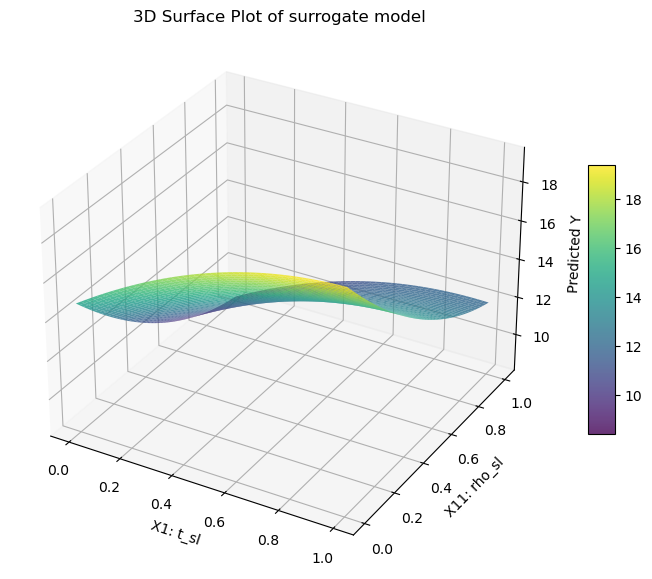

In [14]:
input_name = ['t_sl' ,'t_cor', 't_g', 't_ew', 't_iw',
              'e_sl' ,'e_cor', 'e_g', 'e_ew', 'e_iw',
              'rho_sl' ,'rho_cor', 'rho_g', 'rho_ew', 'rho_iw',
              'soil_vs' ,'soil_rho', 'heig', 'DampR']
FEMU.visualizeSurrogate3D(gpr_fn1_ex220, 19, 0, 10,input_name = input_name)

### Sensitivity analysis

                ST   ST_conf
t_sl      0.198830  0.015392
t_cor     0.002901  0.000292
t_g       0.001198  0.000126
t_ew      0.050108  0.003475
t_iw      0.009284  0.000651
e_sl      0.145365  0.009526
e_cor     0.001347  0.000160
e_g       0.001918  0.000205
e_ew      0.027472  0.002180
e_iw      0.008259  0.000787
rho_sl    0.496530  0.032028
rho_cor   0.001717  0.000190
rho_g     0.001146  0.000126
rho_ew    0.001860  0.000209
rho_iw    0.001456  0.000160
soil_vs   0.046700  0.005071
soil_rho  0.014109  0.001265
heig      0.038007  0.003439
DampR     0.000949  0.000119
                S1   S1_conf
t_sl      0.175197  0.022618
t_cor     0.001061  0.003195
t_g       0.000884  0.001964
t_ew      0.048712  0.014009
t_iw      0.009219  0.005967
e_sl      0.133165  0.022649
e_cor    -0.000701  0.002344
e_g      -0.002294  0.002655
e_ew      0.021471  0.008448
e_iw      0.003344  0.005418
rho_sl    0.487037  0.040363
rho_cor  -0.000046  0.002227
rho_g    -0.000092  0.002148
rho_ew    0.00

D:\MDSI_project/ANSYS_Building_model/PyAPDL_example/FUNC\func_FEMU.py:205: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(var_name, rotation=90)


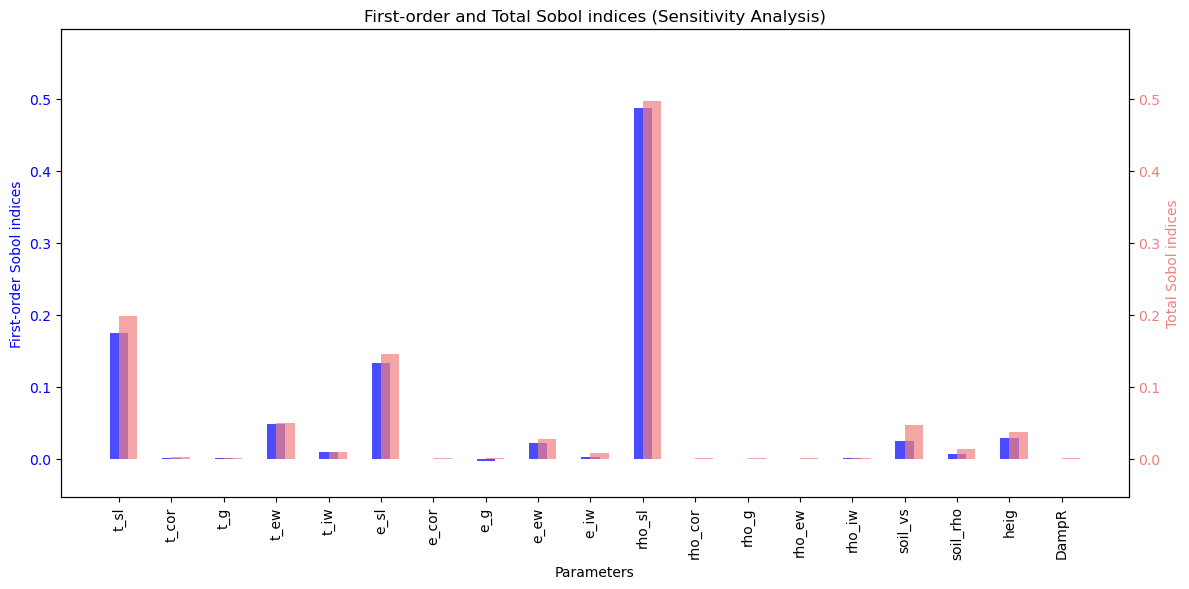

                ST   ST_conf
t_sl      0.521775  0.028841
t_cor     0.006471  0.000676
t_g       0.001025  0.000107
t_ew      0.011513  0.000989
t_iw      0.002726  0.000286
e_sl      0.184193  0.013876
e_cor     0.002116  0.000216
e_g       0.001095  0.000117
e_ew      0.003817  0.000381
e_iw      0.002124  0.000267
rho_sl    0.275479  0.018997
rho_cor   0.001581  0.000207
rho_g     0.001262  0.000155
rho_ew    0.003213  0.000378
rho_iw    0.002457  0.000299
soil_vs   0.002087  0.000240
soil_rho  0.001401  0.000150
heig      0.015139  0.001509
DampR     0.001748  0.000213
                S1   S1_conf
t_sl      0.498550  0.038906
t_cor     0.005497  0.004580
t_g      -0.002047  0.002113
t_ew      0.010103  0.007539
t_iw      0.000141  0.003319
e_sl      0.171029  0.023206
e_cor     0.000335  0.002733
e_g       0.000086  0.001763
e_ew     -0.000220  0.003634
e_iw      0.000375  0.002858
rho_sl    0.255607  0.030175
rho_cor   0.000602  0.002265
rho_g    -0.001466  0.001982
rho_ew    0.00

D:\MDSI_project/ANSYS_Building_model/PyAPDL_example/FUNC\func_FEMU.py:205: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(var_name, rotation=90)


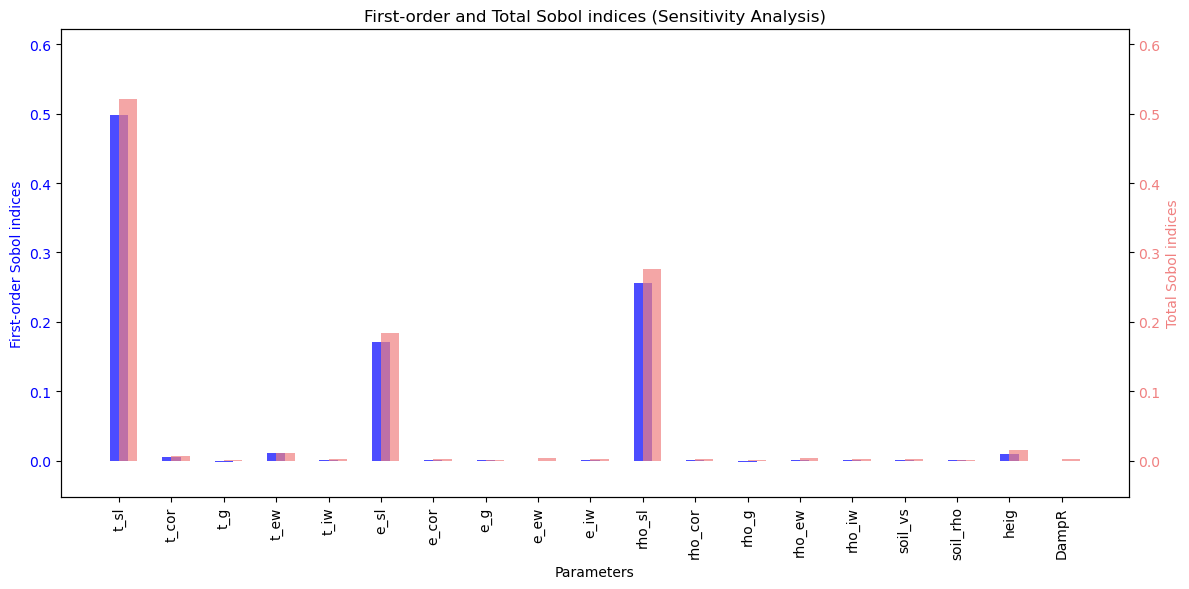

                ST   ST_conf
t_sl      0.179004  0.013516
t_cor     0.003880  0.000363
t_g       0.002004  0.000223
t_ew      0.051709  0.003322
t_iw      0.009003  0.000853
e_sl      0.160902  0.010590
e_cor     0.002112  0.000245
e_g       0.002411  0.000232
e_ew      0.031776  0.002906
e_iw      0.007977  0.000691
rho_sl    0.495230  0.028372
rho_cor   0.001916  0.000171
rho_g     0.001747  0.000190
rho_ew    0.003151  0.000368
rho_iw    0.001777  0.000212
soil_vs   0.043585  0.004213
soil_rho  0.014734  0.001479
heig      0.041271  0.003188
DampR     0.001592  0.000183
                S1   S1_conf
t_sl      0.160421  0.023794
t_cor     0.002222  0.003421
t_g      -0.000792  0.002536
t_ew      0.051554  0.012914
t_iw      0.005500  0.005806
e_sl      0.145311  0.023834
e_cor     0.001608  0.002950
e_g       0.000674  0.003333
e_ew      0.027355  0.010698
e_iw      0.005743  0.005232
rho_sl    0.484280  0.038143
rho_cor   0.002074  0.002635
rho_g     0.000557  0.002686
rho_ew   -0.00

D:\MDSI_project/ANSYS_Building_model/PyAPDL_example/FUNC\func_FEMU.py:205: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(var_name, rotation=90)


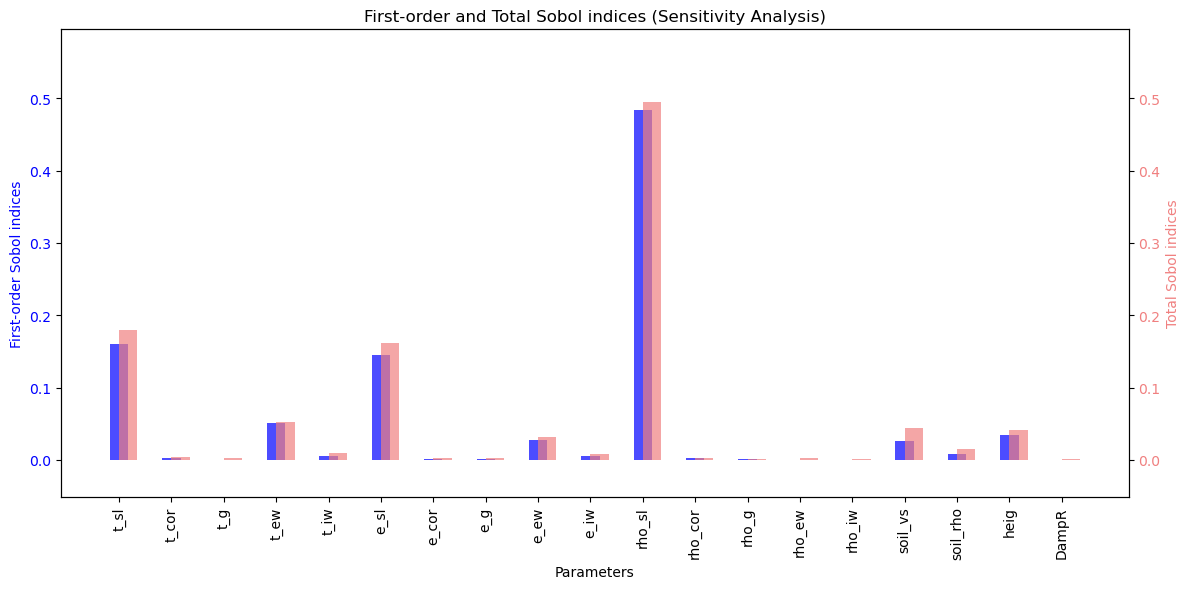

                ST   ST_conf
t_sl      0.424082  0.028579
t_cor     0.006931  0.000686
t_g       0.014623  0.001794
t_ew      0.037414  0.004200
t_iw      0.019193  0.002049
e_sl      0.210494  0.016263
e_cor     0.003803  0.000365
e_g       0.004224  0.000537
e_ew      0.005978  0.000709
e_iw      0.010768  0.001086
rho_sl    0.286333  0.020225
rho_cor   0.008363  0.001327
rho_g     0.007850  0.001048
rho_ew    0.006827  0.000806
rho_iw    0.008134  0.000815
soil_vs   0.009230  0.001201
soil_rho  0.008938  0.001179
heig      0.028931  0.003831
DampR     0.008102  0.001096
                S1   S1_conf
t_sl      0.388300  0.035751
t_cor     0.003102  0.005237
t_g       0.005070  0.006986
t_ew      0.025583  0.012793
t_iw      0.012903  0.009120
e_sl      0.195900  0.026825
e_cor    -0.000005  0.003401
e_g      -0.002930  0.003830
e_ew     -0.000320  0.004816
e_iw      0.001715  0.006055
rho_sl    0.261178  0.027272
rho_cor   0.002412  0.005987
rho_g    -0.000907  0.005324
rho_ew    0.00

D:\MDSI_project/ANSYS_Building_model/PyAPDL_example/FUNC\func_FEMU.py:205: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(var_name, rotation=90)


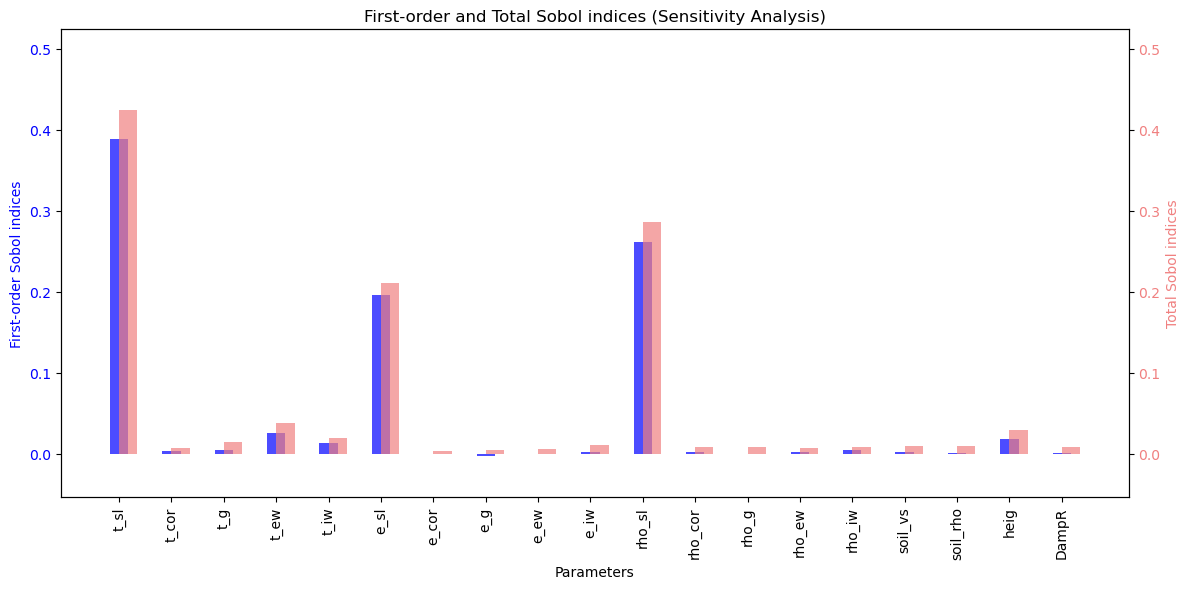

                ST   ST_conf
t_sl      0.187669  0.014637
t_cor     0.002916  0.000278
t_g       0.001196  0.000112
t_ew      0.048752  0.003319
t_iw      0.007843  0.000788
e_sl      0.158846  0.011923
e_cor     0.000926  0.000111
e_g       0.001412  0.000172
e_ew      0.028001  0.002369
e_iw      0.010201  0.000989
rho_sl    0.494339  0.033114
rho_cor   0.001472  0.000137
rho_g     0.000961  0.000098
rho_ew    0.002270  0.000270
rho_iw    0.001421  0.000180
soil_vs   0.047626  0.005431
soil_rho  0.015504  0.001721
heig      0.042527  0.004016
DampR     0.000950  0.000099
                S1   S1_conf
t_sl      0.167267  0.025214
t_cor     0.001579  0.003457
t_g       0.000290  0.002159
t_ew      0.046337  0.013540
t_iw      0.004588  0.005495
e_sl      0.144788  0.021249
e_cor     0.001012  0.001694
e_g       0.000782  0.002358
e_ew      0.024851  0.010928
e_iw      0.007573  0.006033
rho_sl    0.489217  0.036876
rho_cor   0.001865  0.002200
rho_g     0.000383  0.001832
rho_ew   -0.00

D:\MDSI_project/ANSYS_Building_model/PyAPDL_example/FUNC\func_FEMU.py:205: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(var_name, rotation=90)


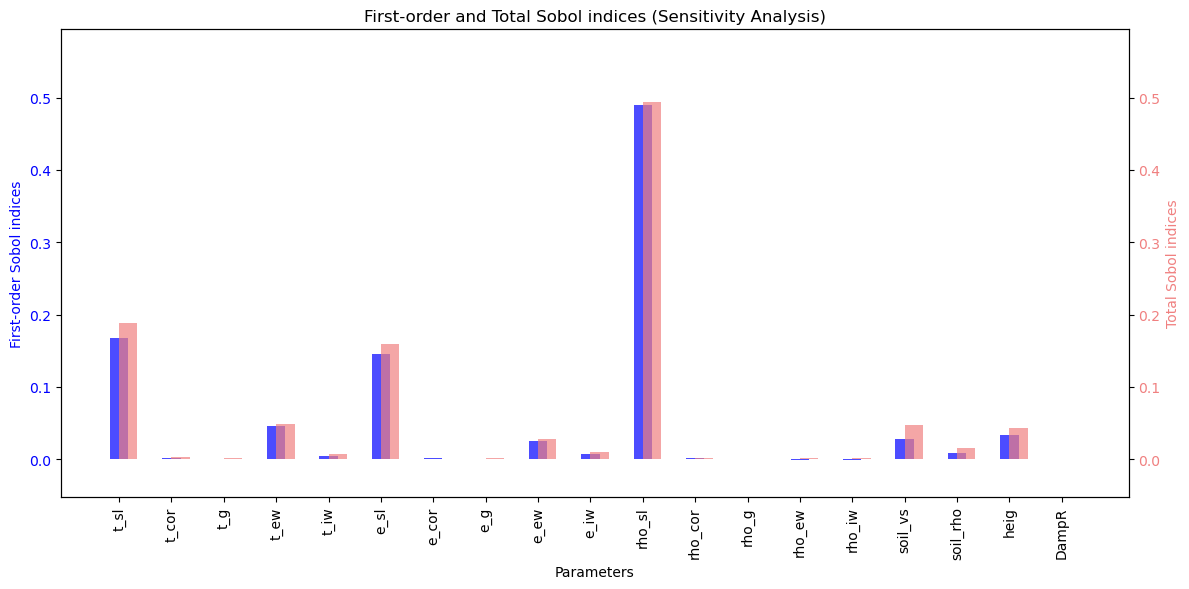

                ST   ST_conf
t_sl      0.486913  0.031950
t_cor     0.007445  0.000756
t_g       0.002757  0.000335
t_ew      0.015674  0.001521
t_iw      0.002642  0.000319
e_sl      0.181989  0.011296
e_cor     0.002377  0.000247
e_g       0.001943  0.000240
e_ew      0.004323  0.000495
e_iw      0.001941  0.000227
rho_sl    0.312432  0.020431
rho_cor   0.004529  0.000538
rho_g     0.002450  0.000304
rho_ew    0.003889  0.000479
rho_iw    0.001302  0.000145
soil_vs   0.002281  0.000258
soil_rho  0.001784  0.000196
heig      0.014461  0.001366
DampR     0.001684  0.000211
                S1   S1_conf
t_sl      0.465596  0.039408
t_cor     0.007147  0.005286
t_g      -0.003051  0.003508
t_ew      0.011250  0.007774
t_iw      0.001248  0.003215
e_sl      0.167430  0.024323
e_cor     0.000823  0.003105
e_g       0.000356  0.002475
e_ew      0.002459  0.004029
e_iw      0.000806  0.002694
rho_sl    0.294334  0.028856
rho_cor   0.003388  0.004719
rho_g    -0.000808  0.003346
rho_ew    0.00

D:\MDSI_project/ANSYS_Building_model/PyAPDL_example/FUNC\func_FEMU.py:205: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(var_name, rotation=90)


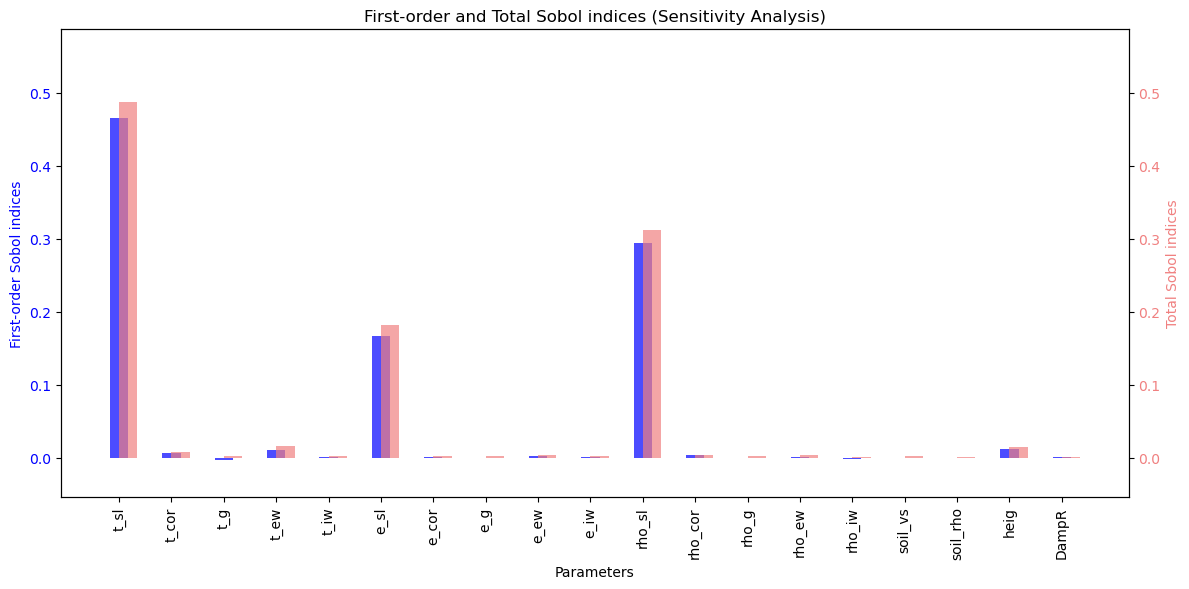

In [15]:
input_name = ['t_sl' ,'t_cor', 't_g', 't_ew', 't_iw',
              'e_sl' ,'e_cor', 'e_g', 'e_ew', 'e_iw',
              'rho_sl' ,'rho_cor', 'rho_g', 'rho_ew', 'rho_iw',
              'soil_vs' ,'soil_rho', 'heig', 'DampR']
Si_fn1_ex22 =  FEMU.sobol_GSA(gpr_fn1_ex22,19,2048,input_name,True)
Si_fn2_ex22 =  FEMU.sobol_GSA(gpr_fn2_ex22,19,2048,input_name,True)

Si_fn1_ex221 =  FEMU.sobol_GSA(gpr_fn1_ex221,19,2048,input_name,True)
Si_fn2_ex221 =  FEMU.sobol_GSA(gpr_fn2_ex221,19,2048,input_name,True)

Si_fn1_ex220 =  FEMU.sobol_GSA(gpr_fn1_ex220,19,2048,input_name,True)
Si_fn2_ex220 =  FEMU.sobol_GSA(gpr_fn2_ex220,19,2048,input_name,True)

### Optimization by GA

$x = argmin \sum_{i=1}^{3}(w_{1}^{i}*(f_{n1,gpr}^{i}-f_{n1,exp}^{i}))^2 + (w_{2}^{i}*(f_{n2,gpr}^{i}-f_{n2,exp}^{i}))^2 $ where $i$ indicates the index of impact tests.

$w_{1}^i = 100$ for $i = 1 \cdots 3$, 

$w_{2}^1 =  w_{2}^3 = 100$ and $w_{2}^2 = 100$ , 

In [ ]:
import numpy as np
from scipy.optimize import minimize
from deap import base, creator, tools, algorithms
from scipy.stats import qmc

# Example surrogate models (replace with your actual GPR models)
def surrogate_fn1_ex22(inputs):
    
    # GPR model for fn1 (natural frequency 1)
    return gpr_fn1_ex22.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex22(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex22.predict(inputs.reshape(1, -1))[0]

def surrogate_fn1_ex220(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn1_ex220.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex220(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex220.predict(inputs.reshape(1, -1))[0]

def surrogate_fn1_ex221(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn1_ex221.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex221(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex221.predict(inputs.reshape(1, -1))[0]

# Objective function: minimize the difference from target
def objective_function(x_):
    #x = np.array(x)
    x = np.random.rand(19)#0.5*np.ones(19)
    x[0] = x_[0]
    x[3] = x_[1]
    x[4] = x_[2]
    x[5] = x_[3]
    x[8] = x_[4]
    x[10] = x_[5]
    x[15] = x_[6]
    x[16] = x_[7]
    x[17] = x_[8]
    fn1_pred_ex22 = surrogate_fn1_ex22(x)
    fn2_pred_ex22 = surrogate_fn2_ex22(x)
    fn1_pred_ex220 = surrogate_fn1_ex220(x)
    fn2_pred_ex220 = surrogate_fn2_ex220(x)
    fn1_pred_ex221 = surrogate_fn1_ex221(x)
    fn2_pred_ex221 = surrogate_fn2_ex221(x)
    return ((100*(fn1_pred_ex22 - mean_fn_1_exp_ex22))**2 + (100*(fn2_pred_ex22 - mean_fn_2_exp_ex22))**2 + (100*(fn1_pred_ex220 - mean_fn_1_exp_ex220))**2 + (100*(fn2_pred_ex220 - mean_fn_2_exp_ex220))**2 +(100*(fn1_pred_ex221 - mean_fn_1_exp_ex221))**2 + (100*(fn2_pred_ex221 - mean_fn_2_exp_ex221))**2,)
    #return ((100*(fn1_pred_ex22 - mean_fn_1_exp_ex22))**2 + (100*(fn2_pred_ex22 - mean_fn_2_exp_ex22))**2 + (100*(fn1_pred_ex220 - mean_fn_1_exp_ex220))**2 + (100*(fn2_pred_ex220 - mean_fn_2_exp_ex220))**2,)

bounds = [(0, 1) for _ in range(9)]  # Example bounds

# Remaining significant parameter: 0,3,4,5,8,10,15,16,17
# Using correlation: 0,3,5,8,9,10,17,18
#bounds[0 ]  = (0,1)
#bounds[3 ]  = (0,1)
#bounds[4 ]  = (0,1)
#bounds[5 ]  = (0,1)
#bounds[8 ]  = (0,1)
#bounds[10] = (0,1)
#bounds[15] = (0,1)
#bounds[16] = (0,1)
bounds[8] = (0.3,0.7)

# Define parameter bounds (example: [(low1, high1), (low2, high2), ...])
#bounds = [(0, 10), (50, 100), (0.1, 1.0)]  # Example bounds for each parameter
num_params = len(bounds)
population_size = 4000  # Define population size

# Generate LHS samples
sampler = qmc.LatinHypercube(d=num_params)  # d = number of parameters
lhs_samples = sampler.random(n=population_size+1)  # Generate population_size samples
scaled_samples = qmc.scale(lhs_samples, [b[0] for b in bounds], [b[1] for b in bounds])  # Scale to bounds

# Custom parameter generator using LHS
lhs_population = scaled_samples.tolist()  # Convert to a list of lists
print(np.shape(lhs_population))
def generate_individual():
    """Populates from the pre-generated LHS samples."""
    if not lhs_population:
        raise ValueError("LHS population is exhausted! Increase the number of samples.")
    return lhs_population.pop(0)

# Define the fitness function (minimization problem)
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimize
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, generate_individual)  # Individual generator
toolbox.register("population", tools.initRepeat, list, toolbox.individual)  # Population generator

# Register genetic operators
toolbox.register("evaluate", objective_function)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Population size and generations
population = toolbox.population(n=population_size)  # Population of 100 individuals

# Run the genetic algorithm
num_generations = 500
result_population, log = algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=num_generations, 
                                             stats=None, halloffame=None, verbose=True)

# Evaluate all individuals and sort them
evaluated_population = [(ind, objective_function(ind)) for ind in result_population]
sorted_population = sorted(evaluated_population, key=lambda x: x[1])  # Sort by fitness

# Top 10 candidates
top_10_candidates = sorted_population[:30]

# Print the results
for idx, (candidate, score) in enumerate(top_10_candidates):
    print(f"Rank {idx+1}: Parameters = {candidate}, Objective = {score}")




In [ ]:
#Rank 1: Parameters = [0.8430145126783642, 0.5013479678553467, 0.1892966976434684, 0.758612814129372, 0.21263157876874153, 0.661156444811273, 0.3487799163117251, 0.34756617848028504, 0.545931404807309], Objective = (0.04928799094026901,)
#Rank 1: Parameters = [0.8792903863184585, 0.48738628230913783, 0.18253231193264552, 0.7406417517520911, 0.3220588432418344, 0.6961499886698258, 0.38340305558917387, 0.3127199018813103, 0.5681489215672068], Objective = (0.001749472181678514,)
#Rank 1: Parameters = [0.8753794005194454, 0.5027304791237548, 0.15877779710932605, 0.7466950560121257, 0.3548728220861326, 0.7117370629437083, 0.3588112535442022, 0.27605709762924735, 0.501187858057962], Objective = (0.3012952596224486,)
#Rank 1: Parameters = [0.8966223456682052, 0.4854720769445074, 0.14219201450326924, 0.7002317277120247, 0.30330624808237217, 0.686840898213142, 0.40820046038101215, 0.29734291742916047, 0.5398441852190957], Objective = (0.09102839297711925,)
#Rank 1: Parameters = [0.8834971776452376, 0.48564564174046787, 0.17499810871377436, 0.6801489368137708, 0.4177785835179026, 0.6633371448683253, 0.3008486236340347, 0.3055536190832143, 0.5465174671318634], Objective = (0.196293364482504,)



#Using random start
#Rank 1: Parameters = [0.8938907302862112, 0.7246919078024261, 0.4861508236673493, 0.7332892614446852, 0.2503903899609574, 0.7681592103291159, 0.42017645719563557, 0.1253517295062988, 0.4196583181019576], Objective = (21.473075823911454,)

### OPtimization by L-BFGS-B

In [ ]:
import numpy as np
from scipy.optimize import minimize


# GA result 0.8430186936984674, 0.5013464881374452, 0.1892947179164055, 0.7586169481399572, 0.21266063482968273, 0.6611568296555667, 0.3488986399993419, 0.3474469743092435, 0.5459044097848611
# Example surrogate models (replace with your actual GPR models)
def surrogate_fn1_ex22(inputs):
    # GPR model for fn1 (natural frequency 1)
    return gpr_fn1_ex22.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex22(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex22.predict(inputs.reshape(1, -1))[0]

def surrogate_fn1_ex220(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn1_ex220.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex220(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex220.predict(inputs.reshape(1, -1))[0]

def surrogate_fn1_ex221(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn1_ex221.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex221(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex221.predict(inputs.reshape(1, -1))[0]

# Objective function: minimize the difference from target
def objective_function(x):
    fn1_pred_ex22 = surrogate_fn1_ex22(x)
    fn2_pred_ex22 = surrogate_fn2_ex22(x)
    fn1_pred_ex220 = surrogate_fn1_ex220(x)
    fn2_pred_ex220 = surrogate_fn2_ex220(x)
    fn1_pred_ex221 = surrogate_fn1_ex221(x)
    fn2_pred_ex221 = surrogate_fn2_ex221(x)
    return (100*(fn1_pred_ex22 - mean_fn_1_exp_ex22))**2 + (100*(fn2_pred_ex22 - mean_fn_2_exp_ex22))**2 + (100*(fn1_pred_ex220 - mean_fn_1_exp_ex220))**2 + (50*(fn2_pred_ex220 - mean_fn_2_exp_ex220))**2 +(1000*(fn1_pred_ex221 - mean_fn_1_exp_ex221))**2 + (1000*(fn2_pred_ex221 - mean_fn_2_exp_ex221))**2
    #return ((fn1_pred - 12.1344)**2) + ((fn2_pred - 18.8672)**2)
    #return (100*(fn1_pred_ex22 - mean_fn_1_exp_ex22))**2 + (100*(fn2_pred_ex22 - mean_fn_2_exp_ex22))**2 + (100*(fn1_pred_ex220 - mean_fn_1_exp_ex220))**2 + (50*(fn2_pred_ex220 - mean_fn_2_exp_ex220))**2
# 
# Bounds for the 19 parameters (adjust as per your problem)
bounds = [(0.5, 0.5) for _ in range(19)]  # Example bounds

bounds[0]  = (0,1)
bounds[3]  = (0,1)
bounds[4]  = (0,1)
bounds[5]  = (0,1)
bounds[8]  = (0,1)
bounds[10] = (0,1)
bounds[15] = (0,1)
bounds[16] = (0,1)
bounds[17] = (0,1)


# Initial guess for the parameters
#x0 = np.random.uniform(0, 1 ,size=19)
id_ = 0
x0 = 0.5*np.ones(19)


x0[0]  = top_10_candidates[id_][0][0]
x0[3]  = top_10_candidates[id_][0][1]
x0[4]  = top_10_candidates[id_][0][2]
x0[5]  = top_10_candidates[id_][0][3]
x0[8]  = top_10_candidates[id_][0][4]
x0[10] = top_10_candidates[id_][0][5]
x0[15] = top_10_candidates[id_][0][6]
x0[16] = top_10_candidates[id_][0][7]
x0[17] = top_10_candidates[id_][0][8]

#x0 = top_10_candidates[5][0]

x_top_10_candidates = np.zeros([10,19])
print(x0)

for i_top in range(1):
    # Perform optimization
    result = minimize(objective_function, x0, bounds=bounds, method='L-BFGS-B')

    # Optimized parameters
    if result.success:
        optimized_params = result.x
        print("Optimized Parameters:", optimized_params)
        print("Objective Function Value:", result.fun)
        print(f"goal fn_1:{mean_fn_1_exp_ex22}, fn_2:{mean_fn_2_exp_ex22}")
        print(f"fn_1: {surrogate_fn1_ex22(result.x)}, fn_2: {surrogate_fn2_ex22(result.x)}")
        print(f"goal fn_1:{mean_fn_1_exp_ex220}, fn_2:{mean_fn_2_exp_ex220}")
        print(f"fn_1: {surrogate_fn1_ex220(result.x)}, fn_2: {surrogate_fn2_ex220(result.x)}")
        print(f"goal fn_1:{mean_fn_1_exp_ex221}, fn_2:{mean_fn_2_exp_ex221}")
        print(f"fn_1: {surrogate_fn1_ex221(result.x)}, fn_2: {surrogate_fn2_ex221(result.x)}")
        x_top_10_candidates[i_top,:] = result.x
        
    else:
        print("Optimization failed:", result.message)

# Identify rows that are not all zeros
non_zero_rows = ~np.all(x_top_10_candidates == 0, axis=1)
# Remove rows with all zeros
x_top_10_candidates = x_top_10_candidates[non_zero_rows]
x_top_10_candidates = np.unique(x_top_10_candidates, axis=0)
print(x_top_10_candidates)


In [ ]:
#X1 = Optimized Parameters: [0.87971335 0.5        0.5        0.48841022 0.18233155 0.74068763
# 0.5        0.5        0.32214149 0.5        0.69677675 0.5
# 0.5        0.5        0.5        0.38348253 0.31367985 0.56850227
# 0.5       ]

#X2 = 

#X3 = Optimized Parameters: [0.88105875 0.5        0.5        0.51659156 0.15505284 0.74853258
# 0.5        0.5        0.35632045 0.5        0.72127802 0.5
# 0.5        0.5        0.5        0.36048623 0.28803446 0.50573232
# 0.5       ]

#X4 = Optimized Parameters: [0.87104107 0.5        0.5        0.47295272 0.13602528 0.7609705
# 0.5        0.5        0.29578253 0.5        0.69371847 0.5
# 0.5        0.5        0.5        0.3958753  0.3276252  0.55483759
# 0.5       ]

#X5 = Optimized Parameters: [0.89931721 0.5        0.5        0.49292277 0.14086951 0.70191221
# 0.5        0.5        0.30400452 0.5        0.69210631 0.5
# 0.5        0.5        0.5        0.40873796 0.30433329 0.54180028
# 0.5       ]

#X6 = Optimized Parameters: [0.88922757 0.5        0.5        0.4959129  0.17076963 0.67987231
# 0.5        0.5        0.42086111 0.5        0.67041264 0.5
# 0.5        0.5        0.5        0.3026558  0.31566614 0.55061148
# 0.5       ]

### Correlation Matrix Heatmap

In [ ]:
# Compute the correlation matrix
correlation_matrix = np.corrcoef(x_top_10_candidates, rowvar=False)

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix Heatmap")
plt.show()

### Checking the effects that vary the non-significant parameters

In [ ]:
def surrogate_fn1_ex22(inputs):
    # GPR model for fn1 (natural frequency 1)
    return gpr_fn1_ex22.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex22(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex22.predict(inputs.reshape(1, -1))[0]

def surrogate_fn1_ex220(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn1_ex220.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex220(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex220.predict(inputs.reshape(1, -1))[0]

def surrogate_fn1_ex221(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn1_ex221.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex221(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex221.predict(inputs.reshape(1, -1))[0]

# Objective function: minimize the difference from target
def objective_function_fn(x):
    penalty_w = 10
    x = np.array(x)
    fn1_pred_ex22 = surrogate_fn1_ex22(x)
    fn2_pred_ex22 = surrogate_fn2_ex22(x)
    fn1_pred_ex220 = surrogate_fn1_ex220(x)
    fn2_pred_ex220 = surrogate_fn2_ex220(x)
    fn1_pred_ex221 = surrogate_fn1_ex221(x)
    fn2_pred_ex221 = surrogate_fn2_ex221(x)
    print(fn1_pred_ex22,fn2_pred_ex22,fn1_pred_ex220,fn2_pred_ex220,fn1_pred_ex221,fn2_pred_ex221)
    total_error = ((mean_fn_1_exp_ex22))**2 + ((mean_fn_2_exp_ex22))**2 + ((mean_fn_1_exp_ex220))**2 + ((mean_fn_2_exp_ex220))**2 +((mean_fn_1_exp_ex221))**2 + ((mean_fn_2_exp_ex221))**2
    return ((penalty_w*(fn1_pred_ex22 - mean_fn_1_exp_ex22))**2 + (penalty_w*(fn2_pred_ex22 - mean_fn_2_exp_ex22))**2 + (penalty_w*(fn1_pred_ex220 - mean_fn_1_exp_ex220))**2 + (penalty_w*(fn2_pred_ex220 - mean_fn_2_exp_ex220))**2 +(penalty_w*(fn1_pred_ex221 - mean_fn_1_exp_ex221))**2 + (penalty_w*(fn2_pred_ex221 - mean_fn_2_exp_ex221))**2)/total_error


x0 = np.array(x_top_10_candidates)[0]
for i in range(30):
    x0[1]  = np.random.rand()
    x0[2]  = np.random.rand()
    x0[6]  = np.random.rand()
    x0[7]  = np.random.rand()
    x0[9]  = np.random.rand()
    x0[11] = np.random.rand()
    x0[12] = np.random.rand()
    x0[13] = np.random.rand()
    x0[14] = np.random.rand()
    x0[18] = np.random.rand()
    print(objective_function_fn(x0))


### Run the simulation for comparison the optmizaed result and expiremental data
- we might need futher optimization process for fine-tunning

In [3]:
simu_tk = simulation_PyAPDL(nproc=4,nerr=10000)
simu_tk.launch_engine()
simu_tk.mapdl.clear()

PyMAPDL is taking longer than expected to connect to an MAPDL session.
Checking if there are any available licenses...
Launch Pymapdl
     Launch Pymapdl successfully, duration 24.6829 seconds.


### Objecttive function for comparison with expirmental data for GP

#### Note of $H_{simu}$ and $H_{exp}$
- In the further GP optimization for the whole FRFs, we will compare the FRFs from 8 channels on the slab at 1OG and 2OG from simulation to exp data. Since we have 3 events, i.e. ex22, ex220, ex221, therefore we will have totally 3(evnets) * 8(channels) = 24 FRFs for whole hammer testings.
- The $H_{simu}$ and $H_{exp}$ are the FRFs from simulation and exp respectively. Each of them have the size [i, N], where the $N$ is the length of the frequency series and $i$ is the index of channels based on each evnets.
  - The index $i$ of rows (axis = 1) following the sequences: $ i = 0 \cdots 7$ is for channels [9,10,11,12,3,13,14,15] for event ex221.
  - The index $i$ of rows (axis = 1) following the sequences: $ i = 8 \cdots 15$ is for channels [9,10,11,12,3,13,14,15] for event ex220. 
  - The index $i$ of rows (axis = 1) following the sequences: $ i = 16 \cdots 13$ is for channels [9,10,11,12,3,13,14,15] for event ex22.

#### Normalization of $H_{simu}$ and $H_{exp}$

- Normalized based on each events. Therefore the normalization of $ i = 0 \cdots 7$,  $ i = 8 \cdots 15$ and $ i = 16 \cdots 13$ are seperated.





 Setting information
     Building inner wall           :  True
     Building stair                :  True
     Building SSI                  :  True
     Element size                  :  0.4
     Height of building            :  3.5302309636
 Assigning parameter
     Rewrite thickness by input
     Rewrite Young's modulus by input
     Rewrite Poisson's ratio by input
     Rewrite Density by input
     Rewrite soil properties by input
 /PREP7 activated
     /PREP7 finished, duration 6.7703 seconds.
Solve model: /SOLU
 Setting information
     Solution type                 :  6
     Start frequency               :  0.001
     End frequency                 :  50
     Freqency increment            :  1
     Number of modes (solu_type=2) :  40
     Damping ratio                 :  0.03
     Excitation node               :  5770
Using Modal-superpostion method
     /SOLU finished, duration 30.0644 seconds.
 Extract all modal information , duration 4.0316 seconds.
 /POST26 actiavted
     /P

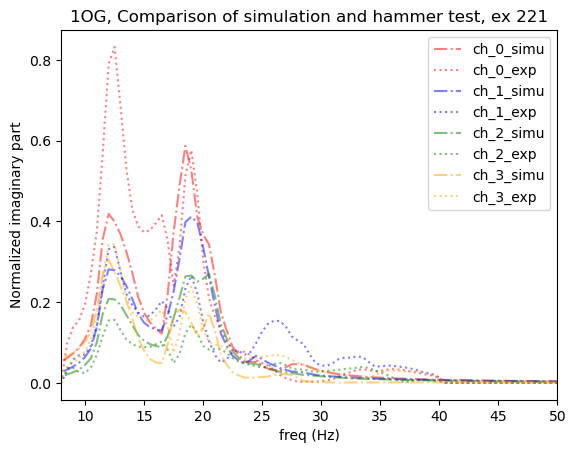

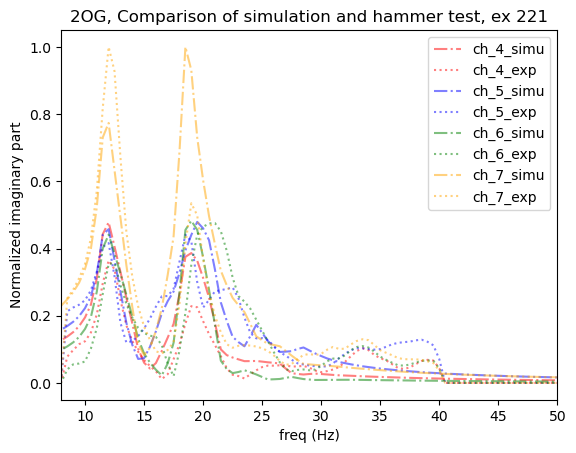

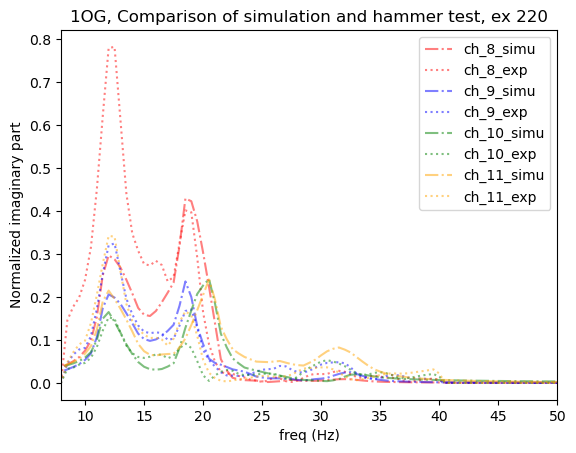

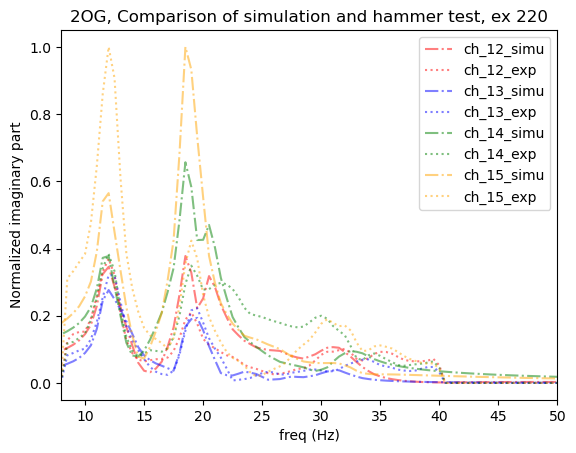

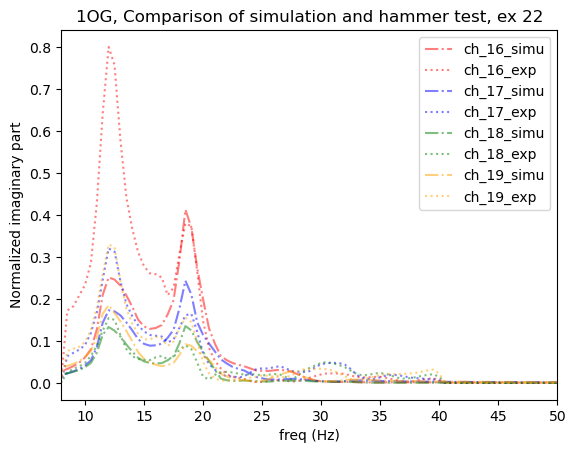

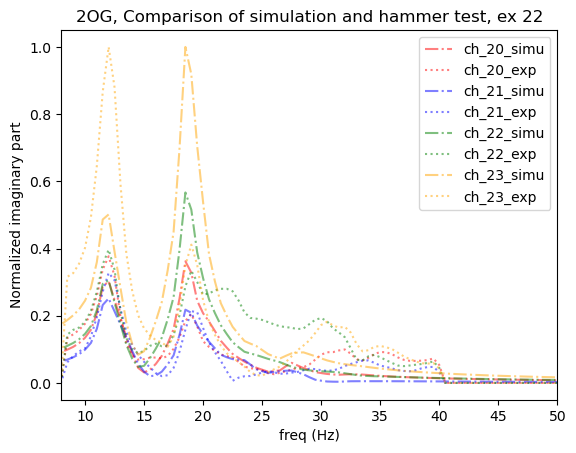

12.2117349 18.8066564 0.6736317421219681 0.7040788314693421
12.2117349 18.6079362 0.7153661045160614 0.767083862336967
12.2117349 19.09273615 0.6513397567084581 0.5344896427779401
0.5791752325826168
12.2117349 18.8066564
12.2117349 18.6079362
12.2117349 19.09273615
0.03648679347722043
0.6156620260598372


(0.5791752325826168,
 array([[0.02018596, 0.02018596, 0.02020383, ..., 0.00423411, 0.00415115,
         0.00407137],
        [0.00641741, 0.00641741, 0.00642632, ..., 0.00376505, 0.0036821 ,
         0.00360234],
        [0.00219066, 0.00219066, 0.0021967 , ..., 0.0032929 , 0.00321316,
         0.00313342],
        ...,
        [0.04089717, 0.04089717, 0.04091068, ..., 0.00312549, 0.00305449,
         0.00298204],
        [0.07320265, 0.07320265, 0.07322292, ..., 0.00909932, 0.0089168 ,
         0.00873573],
        [0.12467886, 0.12467886, 0.12470995, ..., 0.01741972, 0.01701902,
         0.01661971]]))

In [6]:
import os
from IPython.display import clear_output

#def surrogate_fn1_ex22(inputs):
#    # GPR model for fn1 (natural frequency 1)
#    return gpr_fn1_ex22.predict(inputs.reshape(1, -1))[0]
#def surrogate_fn2_ex22(inputs):
#    # GPR model for fn2 (natural frequency 2)
#    return gpr_fn2_ex22.predict(inputs.reshape(1, -1))[0]
#def surrogate_fn1_ex220(inputs):
#    # GPR model for fn2 (natural frequency 2)
#    return gpr_fn1_ex220.predict(inputs.reshape(1, -1))[0]
#def surrogate_fn2_ex220(inputs):
#    # GPR model for fn2 (natural frequency 2)
#    return gpr_fn2_ex220.predict(inputs.reshape(1, -1))[0]
#def surrogate_fn1_ex221(inputs):
#    # GPR model for fn2 (natural frequency 2)
#    return gpr_fn1_ex221.predict(inputs.reshape(1, -1))[0]
#def surrogate_fn2_ex221(inputs):
#    # GPR model for fn2 (natural frequency 2)
#    return gpr_fn2_ex221.predict(inputs.reshape(1, -1))[0]
## Objective function: minimize the difference from target
#def objective_function_fn(x):
#    penalty_w = 25
#    fn1_pred_ex22 = surrogate_fn1_ex22(x)
#    fn2_pred_ex22 = surrogate_fn2_ex22(x)
#    fn1_pred_ex220 = surrogate_fn1_ex220(x)
#    fn2_pred_ex220 = surrogate_fn2_ex220(x)
#    fn1_pred_ex221 = surrogate_fn1_ex221(x)
#    fn2_pred_ex221 = surrogate_fn2_ex221(x)
#    total_error = ((mean_fn_1_exp_ex22))**2 + ((mean_fn_2_exp_ex22))**2 + ((mean_fn_1_exp_ex220))**2 + ((mean_fn_2_exp_ex220))**2 +((mean_fn_1_exp_ex221))**2 + ((mean_fn_2_exp_ex221))**2
#    return ((penalty_w*(fn1_pred_ex22 - mean_fn_1_exp_ex22))**2 + (penalty_w*(fn2_pred_ex22 - mean_fn_2_exp_ex22))**2 + (penalty_w*(fn1_pred_ex220 - mean_fn_1_exp_ex220))**2 + (penalty_w*(fn2_pred_ex220 - mean_fn_2_exp_ex220))**2 +(penalty_w*(fn1_pred_ex221 - mean_fn_1_exp_ex221))**2 + (penalty_w*(fn2_pred_ex221 - mean_fn_2_exp_ex221))**2)/total_error

def objective_function(X_input):
    cut_freq_low = 8
    cut_freq_high = 50
    vary_ratio = 0.5
    X_transformed = 2 * X_input - 1
    X_transformed = X_transformed.reshape(-1,1)
    X_transformed = np.transpose(X_transformed)
    i_doe = 0
    X_doe_transformed = X_transformed
    #
    # Parameter list    = [slab ,corridor, ground, edge_wall, inner_wall, stair ]
    # Parameter list    = [ vs,   rho,   nu ]
    t_para   = np.array([ 0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0],
                        0.8  + vary_ratio*(0.8  )*X_transformed[i_doe,1],
                        0.05 + vary_ratio*(0.05 )*X_transformed[i_doe,2],
                        0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,3],
                        0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,4],
                        0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0]])
    #
    e_para   = np.array([ 20e9 + vary_ratio*20e9*X_transformed[i_doe,5],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,6],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,7],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,8],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,9],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,5]])
    #
    nu_para  = np.array([ 0.27,
                        0.27,
                        0.27,
                        0.27,
                        0.27,
                        0.27])
    #
    rho_para = np.array([ 2300 + vary_ratio*2300*X_transformed[i_doe,10],
                        2300 + vary_ratio*2300*X_transformed[i_doe,11],
                        2300 + vary_ratio*2300*X_transformed[i_doe,12],
                        2300 + vary_ratio*2300*X_transformed[i_doe,13],
                        2300 + vary_ratio*2300*X_transformed[i_doe,14],
                        2300 + vary_ratio*2300*X_transformed[i_doe,10]])
    #
    soil_para = np.array([ 350  + vary_ratio*(350 )*X_transformed[i_doe,15],
                        1400 + vary_ratio*(1400)*X_transformed[i_doe,16],
                        0.33 ])
    #
    height_b            = 3.37 + vary_ratio*3.37*X_transformed[i_doe,17]
    damp_ratio_b        = 0.045+ 0.01*X_transformed[i_doe,18]
    tol = 0.3
    #
    #
    # Start the simulation 
    simu_tk.mapdl.clear()
    simu_tk.setting_parameter(bool_SSI= True,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.1 Pos1 (close to edge)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',12.776-tol,12.776+tol)
    nsel_id_3 = simu_tk.mapdl.nsel('R','LOC','Y',2.748-tol,2.748+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=cut_freq_high,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_3[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex221 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex221 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex221
        }
    simu_tk.mapdl.clear()
    #
    #
    simu_tk.setting_parameter(bool_SSI= True,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.0 Pos2 (sensor)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',7.19-tol,7.19+tol)
    nsel_id_2 = simu_tk.mapdl.nsel('R','LOC','Y',8.14-tol,8.14+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=cut_freq_high,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_2[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex220 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex220 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex220
        }
    simu_tk.mapdl.clear()
    #
    #
    simu_tk.setting_parameter(bool_SSI= True,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.0 Pos1 (shaker)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',9.3-tol,9.3+tol)
    nsel_id_1 = simu_tk.mapdl.nsel('R','LOC','Y',5.9-tol,5.9+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=cut_freq_high,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_1[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex22 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex22 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex22
        }
    #
    simu_tk.mapdl.clear()
    #clear_output(wait=True)
    #
    freq_resample = np.linspace(0, cut_freq_high, 101)
    FRFs_simu = np.zeros([24,len(freq_resample)])
    #
    i_ch_index = 0
    ch_list = [9,10,11,12,3,13,14,15]
    # Case 221
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex221['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex221['meas_frf'][f'disp_ch{i_ch}']['ampl']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    # Case 220
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex220['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex220['meas_frf'][f'disp_ch{i_ch}']['ampl']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    # Case 22
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex22['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex22['meas_frf'][f'disp_ch{i_ch}']['ampl']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    #
    # Split into 3 groups of [8, 101]
    num_groups = 3
    group_size = 8
    normalized_data = np.zeros_like(FRFs_simu)
    #
    for i in range(num_groups):
        # Get the current group
        start_idx = i * group_size
        end_idx = start_idx + group_size
        group = FRFs_simu[start_idx:end_idx, :]  # Shape: [8, 101]
        # Compute normalization value (e.g., max of the group)
        normalization_value = np.max(np.abs(group))
        # Normalize the group
        normalized_data[start_idx:end_idx, :] = group / normalization_value
    #FRFs_simu_norm = FRFs_simu/np.max(np.abs(FRFs_simu))
    FRFs_simu_norm = normalized_data
    #
    #
    ####################################################################################################################################################
    # Import measurement data
    FRFs_exp = np.zeros([24,len(freq_resample)])
    #
    i_pos_1OG = [9,10,11,12,3,13,14,15]
    #cut_freq_low = 8
    #cut_freq_high = 50
    #
    i_file = 9
    directory = os.path.join(project_dir, "MATLAB/Surrogate_main/FRF/")
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        #imag = np.array([frf_data["ampl_"]])[0]
        imag = np.sqrt(np.power(np.array([frf_data["imag_"]])[0],2) + np.power(np.array([frf_data["real_"]])[0],2))
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 40 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i,:] = i_resample
    #
    i_file = 1
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        imag = np.sqrt(np.power(np.array([frf_data["imag_"]])[0],2) + np.power(np.array([frf_data["real_"]])[0],2))
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 40 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i+8,:] = i_resample
    #
    i_file = 13
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        #imag = np.array([frf_data["ampl_"]])[0]
        imag = np.sqrt(np.power(np.array([frf_data["imag_"]])[0],2) + np.power(np.array([frf_data["real_"]])[0],2))
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 40 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i+16,:] = i_resample
    #
    # Split into 3 groups of [8, 101]
    num_groups = 3
    group_size = 8
    normalized_data = np.zeros_like(FRFs_exp)
    #
    for i in range(num_groups):
        # Get the current group
        start_idx = i * group_size
        end_idx = start_idx + group_size
        group = FRFs_exp[start_idx:end_idx, :]  # Shape: [8, 101]
        # Compute normalization value (e.g., max of the group)
        normalization_value = np.max(np.abs(group))
        # Normalize the group
        normalized_data[start_idx:end_idx, :] = group / normalization_value
    #FRFs_simu_norm = FRFs_simu/np.max(np.abs(FRFs_simu))
    FRFs_exp_norm = normalized_data
    #FRFs_exp_norm = FRFs_exp/np.max(np.abs(FRFs_exp))
    #
    #
    error = (FRFs_simu_norm - FRFs_exp_norm)**2

    # Define frequency ranges and factors
    ranges_and_factors = [
        ((14, 17), 10),  # Apply factor 5 to the range [21, 30]
        ((21, 50), 10)   # Apply factor 2 to the range [40, 50]
    ]

    # Generate the mask
    mask = FEMU.generate_mask(freq_resample, ranges_and_factors)
    error = error*mask
    error_percentage = np.sum(error)/np.sum(2*(FRFs_exp_norm)**2)
    #
    color_list = ['red', 'blue', 'green', 'orange']

    for i in range(0,4):
        #plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="-.",color=color_list[i], alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle=":",color=color_list[i], alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("1OG, Comparison of simulation and hammer test, ex 221")
        plt.xlim(cut_freq_low, cut_freq_high)
    plt.show()
    for i in range(4,8):
        #plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="-.",color=color_list[i-4], alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle=":",color=color_list[i-4], alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("2OG, Comparison of simulation and hammer test, ex 221")
        plt.xlim(cut_freq_low, cut_freq_high)
    plt.show()
    for i in range(8,12):
        #plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="-.",color=color_list[i-8], alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle=":",color=color_list[i-8], alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("1OG, Comparison of simulation and hammer test, ex 220")
        plt.xlim(cut_freq_low, cut_freq_high)
    plt.show()
    for i in range(12,16):
        #plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="-.",color=color_list[i-12], alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle=":",color=color_list[i-12], alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("2OG, Comparison of simulation and hammer test, ex 220")
        plt.xlim(cut_freq_low, cut_freq_high)
    plt.show()
    for i in range(16,20):
        #plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="-.",color=color_list[i-16], alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle=":",color=color_list[i-16], alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("1OG, Comparison of simulation and hammer test, ex 22")
        plt.xlim(cut_freq_low, cut_freq_high)
    plt.show()
    for i in range(20,24):
        #plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="-.",color=color_list[i-20], alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle=":",color=color_list[i-20], alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("2OG, Comparison of simulation and hammer test, ex 22")
        plt.xlim(cut_freq_low, cut_freq_high)
    plt.show()
    #
    penalty_w = 25
    fn_1_ex22, fn_2_ex22 = extract_fn(DOE_info_ex22, 13)
    fn_1_ex220, fn_2_ex220 = extract_fn(DOE_info_ex220, 1)
    fn_1_ex221, fn_2_ex221 = extract_fn(DOE_info_ex221, 9)
    total_error = ((fn1_exp_22))**2 + ((fn2_exp_22))**2 + ((fn1_exp_220))**2 + ((fn2_exp_220))**2 +((fn1_exp_221))**2 + ((fn2_exp_221))**2
    fn_error = ((penalty_w*(fn_1_ex22 - fn1_exp_22))**2 + (penalty_w*(fn_2_ex22 -fn2_exp_22))**2 + (penalty_w*(fn_1_ex220 - fn1_exp_220))**2 + (penalty_w*(fn_2_ex220 - fn2_exp_220))**2 +(penalty_w*(fn_1_ex221 - fn1_exp_221))**2 + (penalty_w*(fn_2_ex221 - fn2_exp_221))**2)/total_error
    print(error_percentage)
    print(fn_1_ex22, fn_2_ex22)
    print(fn_1_ex220, fn_2_ex220)
    print(fn_1_ex221, fn_2_ex221)
    print(fn_error)
    print(error_percentage+fn_error)

    return error_percentage,FRFs_simu_norm



x_best1 =  [ 1.0,        0.5,       0.5,           0,         0.5,        0.68722604,
            0.5,        0.5,       0.69845997,    0,         0.85229155, 0.5,
            0.5,        0.5,       0.5,           0.5,       0.5,        0.6,
            0.59828352]

x_best2 = [ 0.88901592, 0.27044889, 0.28554261, 0.01408451, 0.27367161, 0.7319021,
            0.72747765, 0.41692908, 0.21476516, 0.25659874, 0.61753642, 0.7479544,
            0.7999774 , 0.40522151, 0.62167283, 0.75864746, 0.65032564, 0.5237532,
            0.66511448]

#x_best_RD = [0.83629052 0.44722008 0.56284155 0.46165459 0.30330304 0.8110846
#  0.45877398 0.52606213 0.45404988 0.54072992 0.76899581 0.65577164
#  0.51205693 0.37330226 0.40043779 0.15221861 0.34418797 0.2150634
#  0.60079022]

#x_best_RD_2 = [0.81484659 0.46686521 0.5405732  0.48068243 0.2688561  0.81549055
#  0.42925797 0.53702979 0.46147802 0.5422323  0.74408384 0.64249069
  #0.52207918 0.38818366 0.40265408 0.12773497 0.31597417 0.19893539
  #0.57906483]


freq_resample = np.linspace(0, 50, 101)

X_input_u =  [0.84507014, 0.11781025076362162        ,-0.25       ,0.50633148 ,0.1885995  ,0.75976072,
                1.25       , 1.25       ,0.21309783 ,0.49082147361439454      ,0.66487426 ,-0.25       ,
                 0.314471918168712       , -0.25       ,1.0761221325446957        ,0.35020139 ,0.35176575 ,0.54754628,
                -0.25       ]
X_input =  [0.84507014, 0.5        ,0.5        ,0.50633148 ,0.1885995  ,0.75976072,
                0.5       , 0.5        ,0.21309783 ,0.5        ,0.66487426 ,0.5       ,
                0.5       , 0.5        ,0.5        ,0.35020139 ,0.35176575 ,0.54754628,
                0.5       ]
x = [0.84507014, 0.13539517760383665, 1.0, 0.50633148, 0.1885995, 0.75976072, 1.0, 1.0, 0.21309783, 0.5004223475169194, 0.66487426, 0.7993062197679878, 0.6071382305792775, 0.23569906134107818, 0.9707206995435914, 0.35020139, 0.35176575, 0.54754628, 0.0]
objective_function(np.array(X_input_u))

### Using GP for further optimization

#### Objective function

$E_{fn}(x) =\frac{\sum_{i=1}^{3}(w\cdot(f_{n1,gpr}^{i}-f_{n1,exp}^{i}))^2 + (w\cdot(f_{n2,gpr}^{i}-f_{n2,exp}^{i}))^2}{\sum_{i=1}^{3}(f_{n1,exp}^{i})^2 + (f_{n2,exp}^{i})^2} $, where $i$ indicates the index of impact tests, and $w = 25$

 
$E_{FRF}(x) = \frac{\sum_{i=1}^{3}\sum_{j=1}^{8}{(M\cdot(\hat{H}^{i,j}_{simu} - \hat{H}^{i,j}_{exp}))^{2}}}{\sum_{i=1}^{3}\sum_{j=1}^{8}{2(\hat{H}^{i,j}_{exp})^{2}}}$, where $i$ indicates the index of impact tests, $j$ represents the index of channels and $M$ is the mask.

$x = argmin ~ E_{fn}(x) + E_{FRF}(x)$

#### ATTENSION
In the objective function, since our goal is to optimize the non-significant parameter, not the whole paramter sets, therefore we have to first fix the significant parameters  that already optimized in previous section.

As the testing, I just derectly copy them and paste into the objective function (Of course it have better way to do that, but right now I just use this manual method for testing), so in the ```objective_function(X_input_non_significant)```, you can see the ```X_input``` are assinged **inside**, which is the optimzied significant parameters. the ```X_input_non_significant``` as the input only control the non-significant parameters

In [15]:
import os
from IPython.display import clear_output

#def surrogate_fn1_ex22(inputs):
#    # GPR model for fn1 (natural frequency 1)
#    return gpr_fn1_ex22.predict(inputs.reshape(1, -1))[0]
#def surrogate_fn2_ex22(inputs):
#    # GPR model for fn2 (natural frequency 2)
#    return gpr_fn2_ex22.predict(inputs.reshape(1, -1))[0]
#def surrogate_fn1_ex220(inputs):
#    # GPR model for fn2 (natural frequency 2)
#    return gpr_fn1_ex220.predict(inputs.reshape(1, -1))[0]
#def surrogate_fn2_ex220(inputs):
#    # GPR model for fn2 (natural frequency 2)
#    return gpr_fn2_ex220.predict(inputs.reshape(1, -1))[0]
#def surrogate_fn1_ex221(inputs):
#    # GPR model for fn2 (natural frequency 2)
#    return gpr_fn1_ex221.predict(inputs.reshape(1, -1))[0]
#def surrogate_fn2_ex221(inputs):
#    # GPR model for fn2 (natural frequency 2)
#    return gpr_fn2_ex221.predict(inputs.reshape(1, -1))[0]
## Objective function: minimize the difference from target
#def objective_function_fn(x):
#    penalty_w = 25
#    x = np.array(x)
#    fn1_pred_ex22 = surrogate_fn1_ex22(x)
#    fn2_pred_ex22 = surrogate_fn2_ex22(x)
#    fn1_pred_ex220 = surrogate_fn1_ex220(x)
#    fn2_pred_ex220 = surrogate_fn2_ex220(x)
#    fn1_pred_ex221 = surrogate_fn1_ex221(x)
#    fn2_pred_ex221 = surrogate_fn2_ex221(x)
#    total_error = ((mean_fn_1_exp_ex22))**2 + ((mean_fn_2_exp_ex22))**2 + ((mean_fn_1_exp_ex220))**2 + ((mean_fn_2_exp_ex220))**2 +((mean_fn_1_exp_ex221))**2 + ((mean_fn_2_exp_ex221))**2
#    return ((penalty_w*(fn1_pred_ex22 - mean_fn_1_exp_ex22))**2 + (penalty_w*(fn2_pred_ex22 - mean_fn_2_exp_ex22))**2 + (penalty_w*(fn1_pred_ex220 - mean_fn_1_exp_ex220))**2 + (penalty_w*(fn2_pred_ex220 - mean_fn_2_exp_ex220))**2 +(penalty_w*(fn1_pred_ex221 - mean_fn_1_exp_ex221))**2 + (penalty_w*(fn2_pred_ex221 - mean_fn_2_exp_ex221))**2)/total_error



def objective_function(X_input_non_significant):
    #
    #
    #
    X_input_non_significant = np.array(X_input_non_significant)

    X_input =  [0.84507014, 0.5        ,0.5        ,0.50633148 ,0.1885995  ,0.75976072,
                0.5       , 0.5        ,0.21309783 ,0.5        ,0.66487426 ,0.5       ,
                0.5       , 0.5        ,0.5        ,0.35020139 ,0.35176575 ,0.54754628,
                0.5       ]
    
    #X_input = [0.87104107 ,0.5        ,0.5        ,0.47295272 ,0.13602528 ,0.7609705,
    #           0.5        ,0.5        ,0.29578253 ,0.5        ,0.69371847 ,0.5,
    #           0.5        ,0.5        ,0.5        ,0.3958753  ,0.3276252  ,0.55483759,
    #           0.5       ]
    X_input = np.array(X_input)
    X_input[1]  = X_input_non_significant[0]
    X_input[2]  = X_input_non_significant[1]
    X_input[6]  = X_input_non_significant[2]
    X_input[7]  = X_input_non_significant[3]
    X_input[9]  = X_input_non_significant[4]
    X_input[11] = X_input_non_significant[5]
    X_input[12] = X_input_non_significant[6]
    X_input[13] = X_input_non_significant[7]
    X_input[14] = X_input_non_significant[8]
    X_input[18] = X_input_non_significant[9]
    #
    #fn_error = objective_function_fn(X_input)
    #
    vary_ratio = 0.5
    X_transformed = 2 * X_input - 1
    X_transformed = X_transformed.reshape(-1,1)
    X_transformed = np.transpose(X_transformed)
    i_doe = 0
    X_doe_transformed = X_transformed
    #
    # Parameter list    = [slab ,corridor, ground, edge_wall, inner_wall, stair ]
    # Parameter list    = [ vs,   rho,   nu ]
    t_para   = np.array([ 0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0],
                        0.8  + vary_ratio*(0.8  )*X_transformed[i_doe,1],
                        0.05 + vary_ratio*(0.05 )*X_transformed[i_doe,2],
                        0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,3],
                        0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,4],
                        0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0]])
    #
    e_para   = np.array([ 20e9 + vary_ratio*20e9*X_transformed[i_doe,5],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,6],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,7],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,8],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,9],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,5]])
    #
    nu_para  = np.array([ 0.27,
                        0.27,
                        0.27,
                        0.27,
                        0.27,
                        0.27])
    #
    rho_para = np.array([ 2300 + vary_ratio*2300*X_transformed[i_doe,10],
                        2300 + vary_ratio*2300*X_transformed[i_doe,11],
                        2300 + vary_ratio*2300*X_transformed[i_doe,12],
                        2300 + vary_ratio*2300*X_transformed[i_doe,13],
                        2300 + vary_ratio*2300*X_transformed[i_doe,14],
                        2300 + vary_ratio*2300*X_transformed[i_doe,10]])
    #
    soil_para = np.array([ 350  + vary_ratio*(350 )*X_transformed[i_doe,15],
                        1400 + vary_ratio*(1400)*X_transformed[i_doe,16],
                        0.33 ])
    #
    height_b            = 3.37 + vary_ratio*3.37*X_transformed[i_doe,17]
    damp_ratio_b        = 0.045+ 0.01*X_transformed[i_doe,18]
    tol = 0.3
    #
    #
    # Start the simulation 
    simu_tk.mapdl.clear()
    simu_tk.setting_parameter(bool_SSI= True,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.1 Pos1 (close to edge)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',12.776-tol,12.776+tol)
    nsel_id_3 = simu_tk.mapdl.nsel('R','LOC','Y',2.748-tol,2.748+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_3[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex221 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex221 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex221
        }
    simu_tk.mapdl.clear()
    #
    #
    simu_tk.setting_parameter(bool_SSI= True,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.0 Pos2 (sensor)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',7.19-tol,7.19+tol)
    nsel_id_2 = simu_tk.mapdl.nsel('R','LOC','Y',8.14-tol,8.14+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_2[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex220 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex220 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex220
        }
    simu_tk.mapdl.clear()
    #
    #
    simu_tk.setting_parameter(bool_SSI= True,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.0 Pos1 (shaker)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',9.3-tol,9.3+tol)
    nsel_id_1 = simu_tk.mapdl.nsel('R','LOC','Y',5.9-tol,5.9+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_1[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex22 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex22 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex22
        }
    #
    simu_tk.mapdl.clear()
    clear_output(wait=True)
    #
    freq_resample = np.linspace(0, 50, 101)
    FRFs_simu = np.zeros([24,len(freq_resample)])
    #
    i_ch_index = 0
    ch_list = [9,10,11,12,3,13,14,15]
    # Case 221
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex221['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex221['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    # Case 220
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex220['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex220['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    # Case 22
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex22['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex22['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    
    # Split into 3 groups of [8, 101]
    num_groups = 3
    group_size = 8
    normalized_data = np.zeros_like(FRFs_simu)
    #
    for i in range(num_groups):
        # Get the current group
        start_idx = i * group_size
        end_idx = start_idx + group_size
        group = FRFs_simu[start_idx:end_idx, :]  # Shape: [8, 101]
        # Compute normalization value (e.g., max of the group)
        normalization_value = np.max(np.abs(group))
        # Normalize the group
        normalized_data[start_idx:end_idx, :] = group / normalization_value
    #FRFs_simu_norm = FRFs_simu/np.max(np.abs(FRFs_simu))
    FRFs_simu_norm = normalized_data
    #
    #
    ####################################################################################################################################################
    # Import measurement data
    FRFs_exp = np.zeros([24,len(freq_resample)])
    #
    i_pos_1OG = [9,10,11,12,3,13,14,15]
    cut_freq_low = 8
    cut_freq_high = 50
    #
    i_file = 9
    directory = os.path.join(project_dir, "MATLAB/Surrogate_main/FRF/")
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        imag = np.array([frf_data["imag_"]])[0]
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 40 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i,:] = i_resample
    #
    i_file = 1
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        imag = np.array([frf_data["imag_"]])[0]
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 40 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i+8,:] = i_resample
    #
    i_file = 13
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        imag = np.array([frf_data["imag_"]])[0]
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 40 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i+16,:] = i_resample
    #
    # Split into 3 groups of [8, 101]
    num_groups = 3
    group_size = 8
    normalized_data = np.zeros_like(FRFs_exp)
    #
    for i in range(num_groups):
        # Get the current group
        start_idx = i * group_size
        end_idx = start_idx + group_size
        group = FRFs_exp[start_idx:end_idx, :]  # Shape: [8, 101]
        # Compute normalization value (e.g., max of the group)
        normalization_value = np.max(np.abs(group))
        # Normalize the group
        normalized_data[start_idx:end_idx, :] = group / normalization_value
    #FRFs_simu_norm = FRFs_simu/np.max(np.abs(FRFs_simu))
    FRFs_exp_norm = normalized_data
    #FRFs_exp_norm = FRFs_exp/np.max(np.abs(FRFs_exp))
    #
    #
    error = (FRFs_simu_norm - FRFs_exp_norm)**2
    # Define frequency ranges and factors
    ranges_and_factors = [
        ((14, 17), 5),  # Apply factor 5 to the range [21, 30]
        ((21, 50), 3)   # Apply factor 2 to the range [40, 50]
    ]
    mask = FEMU.generate_mask(freq_resample, ranges_and_factors)
    error = error*mask
    error_percentage = np.sum(error)/np.sum(2*(FRFs_exp_norm)**2)
    error_percentage = np.sum(error)/np.sum(2*(FRFs_exp_norm)**2)
    #
    # Regularazation of parameter 0,3,4,5,8,10,15,16,17
    #
    penalty_w = 25
    fn_1_ex22, fn_2_ex22 = extract_fn(DOE_info_ex22, 13)
    fn_1_ex220, fn_2_ex220 = extract_fn(DOE_info_ex220, 1)
    fn_1_ex221, fn_2_ex221 = extract_fn(DOE_info_ex221, 9)
    total_error = ((fn1_exp_22))**2 + ((fn2_exp_22))**2 + ((fn1_exp_220))**2 + ((fn2_exp_220))**2 +((fn1_exp_221))**2 + ((fn2_exp_221))**2
    fn_error = ((penalty_w*(fn_1_ex22 - fn1_exp_22))**2 + (penalty_w*(fn_2_ex22 -fn2_exp_22))**2 + (penalty_w*(fn_1_ex220 - fn1_exp_220))**2 + (penalty_w*(fn_2_ex220 - fn2_exp_220))**2 +(penalty_w*(fn_1_ex221 - fn1_exp_221))**2 + (penalty_w*(fn_2_ex221 - fn2_exp_221))**2)/total_error
    print(error_percentage)
    #print(fn_1_ex22, fn_2_ex22)
    #print(fn_1_ex220, fn_2_ex220)
    #print(fn_1_ex221, fn_2_ex221)
    print(fn_error)
    print(error_percentage+fn_error)
    total_error_obj = error_percentage + fn_error
    #total_error_obj = error_percentage
    return total_error_obj

#error_per = objective_function([0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5])



### GP optimization

12.1526329 18.9782953 0.617649181516874 0.6307000818932215
12.1526324 18.1906586 0.5800370157328645 0.6383502106501558
12.1526324 19.33400115 0.806478912490498 0.6705711127010913
0.6602434488043788
0.20193352273536846
0.8621769715397473
Iteration 101
Current Best Parameters: [0.11781025076362162, -0.25, 1.25, 1.25, 0.49082147361439454, -0.25, 0.314471918168712, -0.25, 1.0761221325446957, -0.25]
Current Best Objective Value: 0.4560540670154089
----------------------------------------
Best objective value: 0.4560540670154089
Best parameters:
x1: 0.1178
x2: -0.2500
x3: 1.2500
x4: 1.2500
x5: 0.4908
x6: -0.2500
x7: 0.3145
x8: -0.2500
x9: 1.0761
x10: -0.2500
[0.11781025076362162, -0.25, 1.25, 1.25, 0.49082147361439454, -0.25, 0.314471918168712, -0.25, 1.0761221325446957, -0.25]


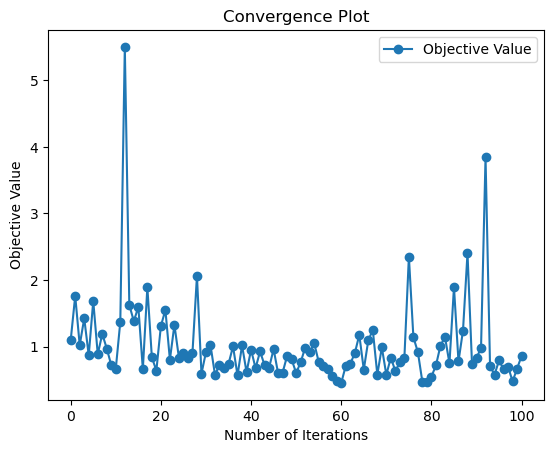

In [16]:
import numpy as np
from skopt import gp_minimize
#from skopt import forest_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# Using Maximin Sampling (Greedy Algorithm)
from scipy.spatial.distance import cdist

# Initial guess
#initial_point_best = np.mean(x_top_10_candidates, axis=0)
#initial_point_best = np.array([0.86163584, 0.59728558, 0.67887033, 0.3799163,  0.54705921, 0.68827147,
#0.63660772, 0.39303398, 0.30927521, 0.4905672,  0.72109263, 0.52573776,
# 0.67194132, 0.11590521, 0.51403692, 0.35758634, 0.3907657,  0.55461558,
# 0.53289235])


#[0.84301451 0.5        0.5        0.50134797 0.1892967  0.75861281
# 0.5        0.5        0.21263158 0.5        0.66115644 0.5
# 0.5        0.5        0.5        0.34877992 0.34756618 0.5459314
# 0.5       ]
#Optimized Parameters: [0.84507014 0.5        0.5        0.50633148 0.1885995  0.75976072
# 0.5        0.5        0.21309783 0.5        0.66487426 0.5
# 0.5        0.5        0.5        0.35020139 0.35176575 0.54754628
# 0.5       ]

initial_point_best = [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]

# Create bounds by adding/subtracting 0.5 and clamping to [0, 1]
#bound = [(max(0, val - 0.25), min(1, val + 0.25)) for val in initial_point_best]
bound = [(-0.25,1.25) for val in initial_point_best]
# Convert to skopt's Real dimensions for optimization
bounds = [Real(low, high, name=f"x{i}") for i, (low, high) in enumerate(bound)]
# Evaluate the objective function at these initial points
initial_values_best = objective_function(initial_point_best) 


## Also input the infromation from previous simulation
#initial_points = np.vstack([selected_samples, initial_point_best])
#initial_values = np.append(error_fn_init, initial_values_best)

initial_points = np.array(initial_point_best)
initial_values = np.array(initial_values_best)


# Define a callback function to print the current state
def print_progress(res):
    print(f"Iteration {len(res.x_iters)}")
    print(f"Current Best Parameters: {res.x}")
    print(f"Current Best Objective Value: {res.fun}")
    print("-" * 40)

# Convert the objective function to use named arguments
@use_named_args(bounds)
def wrapped_objective(**params):
    return objective_function(list(params.values()))

# Run Gaussian Process Optimization
result = gp_minimize(
    func=wrapped_objective,
    dimensions=bounds,
    n_calls=100,  # Total evaluations, including initial points
    n_initial_points=0,    
    x0=initial_points.tolist(),
    y0=initial_values.tolist(),
    random_state=42,
    callback=[print_progress]
)

# Display the results
print("Best objective value:", result.fun)
print("Best parameters:")
for i, param in enumerate(result.x):
    print(f"x{i+1}: {param:.4f}")
print(result.x)

# Visualize progress of the optimization
import matplotlib.pyplot as plt
plt.plot(result.func_vals, marker='o', label="Objective Value")
plt.xlabel("Number of Iterations")
plt.ylabel("Objective Value")
plt.title("Convergence Plot")
plt.legend()
plt.show()


### Validation of the final result

In [22]:
import os
from IPython.display import clear_output

DOE_info = {}
vary_ratio = 0.5

x_best1 =  [ 1.0,        0.5,       0.5,           0,         0.5,        0.68722604,
            0.5,        0.5,       0.69845997,    0,         0.85229155, 0.5,
            0.5,        0.5,       0.5,           0.5,       0.5,        0.6,
            0.59828352]

x_best2 = [ 0.88901592, 0.27044889, 0.28554261, 0.01408451, 0.27367161, 0.7319021,
            0.72747765, 0.41692908, 0.21476516, 0.25659874, 0.61753642, 0.7479544,
            0.7999774 , 0.40522151, 0.62167283, 0.75864746, 0.65032564, 0.5237532,
            0.66511448]

x_best_trial_04853 = [0.8066767551956717, 0.09692069778182295, 0.8325449913333602, 0.21048132516462145, 0.0, 0.6727064043755804, 0.24677257381072, 0.5730031436947602, 0.48020306862804085, 0.8479644185084424, 0.4590951072007893, 0.0, 0.6599936708355071, 0.29010755107378927, 0.7538300170833288, 0.0, 0.6957457662851698, 0.6823013244029553, 0.46385322880717933]
x_best_trail_03148 = [0.863642698252246, 0.7494195145402561, 0.8955970255486806, 0.14818889415764658, 0.555311219588681, 0.711934204161282, 0.7571933518469833, 0.8486787308791819, 0.26263069774387404, 0.7294790051229946, 0.6809443301995914, 0.04053136165183604, 0.6344951772338517, 0.9590229005506244, 0.4587779472965176, 0.673689822702624, 0.6303936220560132, 0.6746004441010262, 0.5465751085388425]

x_oriignal = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

#X_input =  [0.84507014, 0.5        ,0.5        ,0.50633148 ,0.1885995  ,0.75976072,
#            0.5       , 0.5        ,0.21309783 ,0.5        ,0.66487426 ,0.5       ,
#            0.5       , 0.5        ,0.5        ,0.35020139 ,0.35176575 ,0.54754628,
#            0.5       ]

X_input = [0.87104107 ,0.5        ,0.5        ,0.47295272 ,0.13602528 ,0.7609705,
           0.5        ,0.5        ,0.29578253 ,0.5        ,0.69371847 ,0.5,
           0.5        ,0.5        ,0.5        ,0.3958753  ,0.3276252  ,0.55483759,
           0.5       ]
X_input = np.array(X_input)
# The result.x is from the best result of gp_minimize()
X_input[1]  = result.x[0]
X_input[2]  = result.x[1]
X_input[6]  = result.x[2]
X_input[7]  = result.x[3]
X_input[9]  = result.x[4]
X_input[11] = result.x[5]
X_input[12] = result.x[6]
X_input[13] = result.x[7]
X_input[14] = result.x[8]
X_input[18] = result.x[9]

#x_best = result.x
#x_best = np.array(x_top_10_candidates)
x_best = X_input
# Transform X from [0,1] to [-1,1]
#X_transformed = 2 * result.x - 1
X_transformed = 2 * x_best - 1
X_transformed = X_transformed.reshape(-1,1)
X_transformed = np.transpose(X_transformed)
i_doe = 0
X_doe_transformed = X_transformed

# Parameter list    = [slab ,corridor, ground, edge_wall, inner_wall, stair ]
# Parameter list    = [ vs,   rho,   nu ]
t_para   = np.array([ 0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0],
                      0.8  + vary_ratio*(0.8  )*X_transformed[i_doe,1],
                      0.05 + vary_ratio*(0.05 )*X_transformed[i_doe,2],
                      0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,3],
                      0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,4],
                      0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0]])
#
e_para   = np.array([ 20e9 + vary_ratio*20e9*X_transformed[i_doe,5],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,6],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,7],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,8],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,9],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,5]])
#
nu_para  = np.array([ 0.27,
                      0.27,
                      0.27,
                      0.27,
                      0.27,
                      0.27])
#
rho_para = np.array([ 2300 + vary_ratio*2300*X_transformed[i_doe,10],
                      2300 + vary_ratio*2300*X_transformed[i_doe,11],
                      2300 + vary_ratio*2300*X_transformed[i_doe,12],
                      2300 + vary_ratio*2300*X_transformed[i_doe,13],
                      2300 + vary_ratio*2300*X_transformed[i_doe,14],
                      2300 + vary_ratio*2300*X_transformed[i_doe,10]])
#
soil_para = np.array([ 350  + vary_ratio*(350 )*X_transformed[i_doe,15],
                       1400 + vary_ratio*(1400)*X_transformed[i_doe,16],
                       0.33 ])
#
height_b            = 3.37 + vary_ratio*3.37*X_transformed[i_doe,17]
damp_ratio_b        = 0.045+ 0.01*X_transformed[i_doe,18]
tol = 0.3

# Start the simulation 
simu_tk.mapdl.clear()
simu_tk.setting_parameter(bool_SSI= True,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
simu_tk.build_model()
# Excitation point: Hammer 2.1 Pos1 (close to edge)
simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
simu_tk.mapdl.nsel('R','LOC','X',12.776-tol,12.776+tol)
nsel_id_3 = simu_tk.mapdl.nsel('R','LOC','Y',2.748-tol,2.748+tol)
simu_tk.mapdl.nsel('ALL')
# Apply the force on selected node and solve 
simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_3[1])
modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
## Get FRF at target point
meas_FRFs_ex221 = simu_tk.get_FRFs_meas_EXAMPLE()
DOE_info_ex221 = {
    'id':i_doe,
    'X':x_best.tolist(),
    'X_trans':X_doe_transformed.tolist(),
    't_info':simu_tk.t_arr.tolist(),
    'e_info':simu_tk.e_arr.tolist(),
    'n_info':simu_tk.nu_arr.tolist(),
    'r_info':simu_tk.rho_arr.tolist(),
    's_info':simu_tk.soil_arr.tolist(),
    'height':simu_tk.height,
    'dr':simu_tk.Damping_ratio,
    'modal_info':modal_info,
    'meas_frf':meas_FRFs_ex221
    }
simu_tk.mapdl.clear()



simu_tk.setting_parameter(bool_SSI= True,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
simu_tk.build_model()
# Excitation point: Hammer 2.0 Pos2 (sensor)
simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
simu_tk.mapdl.nsel('R','LOC','X',7.19-tol,7.19+tol)
nsel_id_2 = simu_tk.mapdl.nsel('R','LOC','Y',8.14-tol,8.14+tol)
simu_tk.mapdl.nsel('ALL')
# Apply the force on selected node and solve 
simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_2[1])
modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
## Get FRF at target point
meas_FRFs_ex220 = simu_tk.get_FRFs_meas_EXAMPLE()
DOE_info_ex220 = {
    'id':i_doe,
    'X':x_best.tolist(),
    'X_trans':X_doe_transformed.tolist(),
    't_info':simu_tk.t_arr.tolist(),
    'e_info':simu_tk.e_arr.tolist(),
    'n_info':simu_tk.nu_arr.tolist(),
    'r_info':simu_tk.rho_arr.tolist(),
    's_info':simu_tk.soil_arr.tolist(),
    'height':simu_tk.height,
    'dr':simu_tk.Damping_ratio,
    'modal_info':modal_info,
    'meas_frf':meas_FRFs_ex220
    }
simu_tk.mapdl.clear()



simu_tk.setting_parameter(bool_SSI= True,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
simu_tk.build_model()
# Excitation point: Hammer 2.0 Pos1 (shaker)
simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
simu_tk.mapdl.nsel('R','LOC','X',9.3-tol,9.3+tol)
nsel_id_1 = simu_tk.mapdl.nsel('R','LOC','Y',5.9-tol,5.9+tol)
simu_tk.mapdl.nsel('ALL')
# Apply the force on selected node and solve 
simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_1[1])
modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
## Get FRF at target point
meas_FRFs_ex22 = simu_tk.get_FRFs_meas_EXAMPLE()
DOE_info_ex22 = {
    'id':i_doe,
    'X':x_best.tolist(),
    'X_trans':X_doe_transformed.tolist(),
    't_info':simu_tk.t_arr.tolist(),
    'e_info':simu_tk.e_arr.tolist(),
    'n_info':simu_tk.nu_arr.tolist(),
    'r_info':simu_tk.rho_arr.tolist(),
    's_info':simu_tk.soil_arr.tolist(),
    'height':simu_tk.height,
    'dr':simu_tk.Damping_ratio,
    'modal_info':modal_info,
    'meas_frf':meas_FRFs_ex22
    }

simu_tk.mapdl.clear()
clear_output(wait=True)

print(DOE_info_ex22['t_info'])
print(DOE_info_ex22['e_info'])
print(DOE_info_ex22['r_info'])
print(DOE_info_ex22['s_info'])
print(DOE_info_ex22['height'])
print(DOE_info_ex22['dr'])




NameError: name 'result' is not defined

### Visualization
- same as above code, just use for Visualization in convience.

In [4]:
def objective_function_validation(X_input):
    
    cut_freq_low = 8
    cut_freq_high = 50
    vary_ratio = 0.5
    X_transformed = 2 * X_input - 1
    X_transformed = X_transformed.reshape(-1,1)
    X_transformed = np.transpose(X_transformed)
    i_doe = 0
    X_doe_transformed = X_transformed
    #
    # Parameter list    = [slab ,corridor, ground, edge_wall, inner_wall, stair ]
    # Parameter list    = [ vs,   rho,   nu ]
    t_para   = np.array([ 0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0],
                        0.8  + vary_ratio*(0.8  )*X_transformed[i_doe,1],
                        0.05 + vary_ratio*(0.05 )*X_transformed[i_doe,2],
                        0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,3],
                        0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,4],
                        0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0]])
    #
    e_para   = np.array([ 20e9 + vary_ratio*20e9*X_transformed[i_doe,5],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,6],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,7],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,8],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,9],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,5]])
    #
    nu_para  = np.array([ 0.27,
                        0.27,
                        0.27,
                        0.27,
                        0.27,
                        0.27])
    #
    rho_para = np.array([ 2300 + vary_ratio*2300*X_transformed[i_doe,10],
                        2300 + vary_ratio*2300*X_transformed[i_doe,11],
                        2300 + vary_ratio*2300*X_transformed[i_doe,12],
                        2300 + vary_ratio*2300*X_transformed[i_doe,13],
                        2300 + vary_ratio*2300*X_transformed[i_doe,14],
                        2300 + vary_ratio*2300*X_transformed[i_doe,10]])
    #
    soil_para = np.array([ 350  + vary_ratio*(350 )*X_transformed[i_doe,15],
                        1400 + vary_ratio*(1400)*X_transformed[i_doe,16],
                        0.33 ])
    #
    height_b            = 3.37 + vary_ratio*3.37*X_transformed[i_doe,17]
    damp_ratio_b        = 0.045+ 0.01*X_transformed[i_doe,18]
    tol = 0.3
    #
    #
    # Start the simulation 
    simu_tk.mapdl.clear()
    simu_tk.setting_parameter(bool_SSI= True,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.1 Pos1 (close to edge)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',12.776-tol,12.776+tol)
    nsel_id_3 = simu_tk.mapdl.nsel('R','LOC','Y',2.748-tol,2.748+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=cut_freq_high,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_3[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex221 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex221 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex221
        }
    simu_tk.mapdl.clear()
    #
    #
    simu_tk.setting_parameter(bool_SSI= True,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.0 Pos2 (sensor)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',7.19-tol,7.19+tol)
    nsel_id_2 = simu_tk.mapdl.nsel('R','LOC','Y',8.14-tol,8.14+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=cut_freq_high,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_2[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex220 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex220 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex220
        }
    simu_tk.mapdl.clear()
    #
    #
    simu_tk.setting_parameter(bool_SSI= True,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.0 Pos1 (shaker)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',9.3-tol,9.3+tol)
    nsel_id_1 = simu_tk.mapdl.nsel('R','LOC','Y',5.9-tol,5.9+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=cut_freq_high,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_1[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex22 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex22 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex22
        }
    #
    simu_tk.mapdl.clear()
    #clear_output(wait=True)
    #
    freq_resample = np.linspace(0, cut_freq_high, 101)
    FRFs_simu = np.zeros([24,len(freq_resample)])
    #
    i_ch_index = 0
    ch_list = [9,10,11,12,3,13,14,15]
    # Case 221
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex221['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex221['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    # Case 220
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex220['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex220['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    # Case 22
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex22['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex22['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    #
    # Split into 3 groups of [8, 101]
    num_groups = 3
    group_size = 8
    normalized_data = np.zeros_like(FRFs_simu)
    #
    for i in range(num_groups):
        # Get the current group
        start_idx = i * group_size
        end_idx = start_idx + group_size
        group = FRFs_simu[start_idx:end_idx, :]  # Shape: [8, 101]
        # Compute normalization value (e.g., max of the group)
        normalization_value = np.max(np.abs(group))
        # Normalize the group
        normalized_data[start_idx:end_idx, :] = group / normalization_value
    #FRFs_simu_norm = FRFs_simu/np.max(np.abs(FRFs_simu))
    FRFs_simu_norm = normalized_data
    #
    #
    ####################################################################################################################################################
    # Import measurement data
    FRFs_exp = np.zeros([24,len(freq_resample)])
    #
    i_pos_1OG = [9,10,11,12,3,13,14,15]
    #cut_freq_low = 8
    #cut_freq_high = 50
    #
    i_file = 9
    directory = os.path.join(project_dir, "MATLAB/Surrogate_main/FRF/")
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        imag = np.array([frf_data["imag_"]])[0]
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 40 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i,:] = i_resample
    #
    i_file = 1
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        imag = np.array([frf_data["imag_"]])[0]
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 40 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i+8,:] = i_resample
    #
    i_file = 13
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        imag = np.array([frf_data["imag_"]])[0]
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 40 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i+16,:] = i_resample
    #
    # Split into 3 groups of [8, 101]
    num_groups = 3
    group_size = 8
    normalized_data = np.zeros_like(FRFs_exp)
    #
    for i in range(num_groups):
        # Get the current group
        start_idx = i * group_size
        end_idx = start_idx + group_size
        group = FRFs_exp[start_idx:end_idx, :]  # Shape: [8, 101]
        # Compute normalization value (e.g., max of the group)
        normalization_value = np.max(np.abs(group))
        # Normalize the group
        normalized_data[start_idx:end_idx, :] = group / normalization_value
    #FRFs_simu_norm = FRFs_simu/np.max(np.abs(FRFs_simu))
    FRFs_exp_norm = normalized_data
    #FRFs_exp_norm = FRFs_exp/np.max(np.abs(FRFs_exp))

    

    color_list = ['red', 'blue', 'green', 'orange']

    for i in range(0,4):
        #plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="-.",color=color_list[i], alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle=":",color=color_list[i], alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("1OG, Comparison of simulation and hammer test, ex 221")
    plt.show()
    for i in range(4,8):
        #plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="-.",color=color_list[i-4], alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle=":",color=color_list[i-4], alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("2OG, Comparison of simulation and hammer test, ex 221")
    plt.show()
    for i in range(8,12):
        #plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="-.",color=color_list[i-8], alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle=":",color=color_list[i-8], alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("1OG, Comparison of simulation and hammer test, ex 220")
    plt.show()
    for i in range(12,16):
        #plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="-.",color=color_list[i-12], alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle=":",color=color_list[i-12], alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("2OG, Comparison of simulation and hammer test, ex 220")
    plt.show()
    for i in range(16,20):
        #plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="-.",color=color_list[i-16], alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle=":",color=color_list[i-16], alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("1OG, Comparison of simulation and hammer test, ex 22")
    plt.show()
    for i in range(20,24):
        #plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="-.",color=color_list[i-20], alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle=":",color=color_list[i-20], alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("2OG, Comparison of simulation and hammer test, ex 22")
    plt.show()

 Setting information
     Building inner wall           :  True
     Building stair                :  True
     Building SSI                  :  True
     Element size                  :  0.4
     Height of building            :  3.5302309636
 Assigning parameter
     Rewrite thickness by input
     Rewrite Young's modulus by input
     Rewrite Poisson's ratio by input
     Rewrite Density by input
     Rewrite soil properties by input
 /PREP7 activated
     /PREP7 finished, duration 9.0957 seconds.
Solve model: /SOLU
 Setting information
     Solution type                 :  6
     Start frequency               :  0.001
     End frequency                 :  50
     Freqency increment            :  1
     Number of modes (solu_type=2) :  40
     Damping ratio                 :  0.03
     Excitation node               :  5770
Using Modal-superpostion method
     /SOLU finished, duration 40.2117 seconds.
 Extract all modal information , duration 5.2188 seconds.
 /POST26 actiavted
     /P

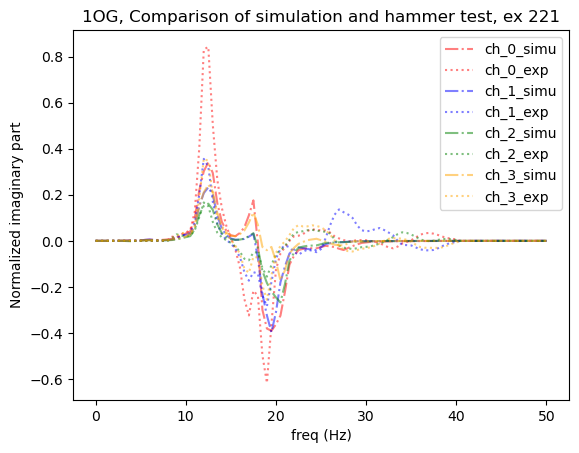

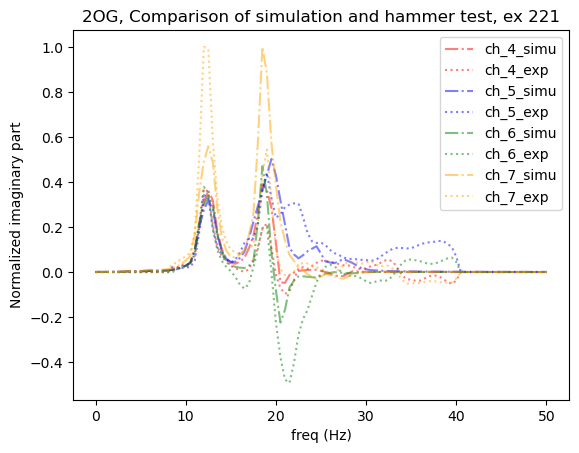

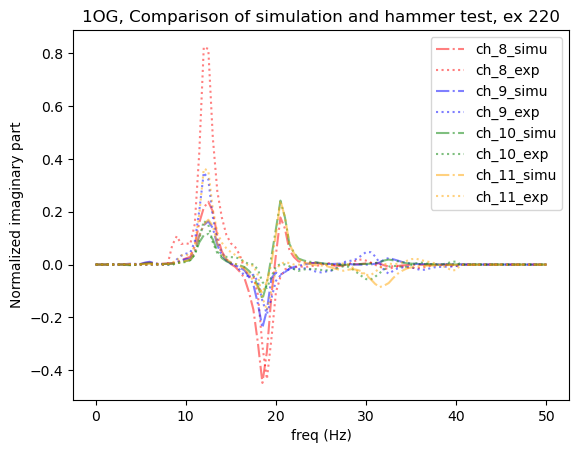

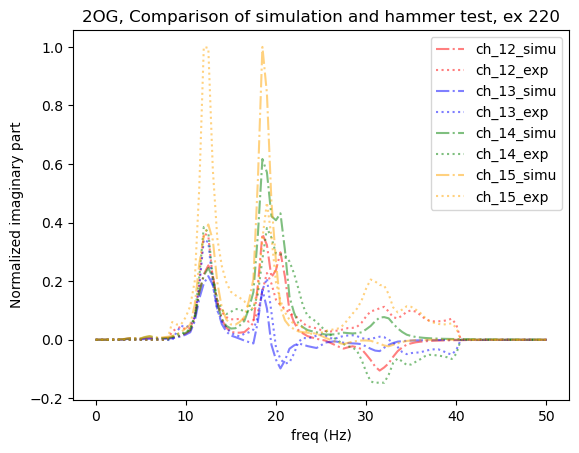

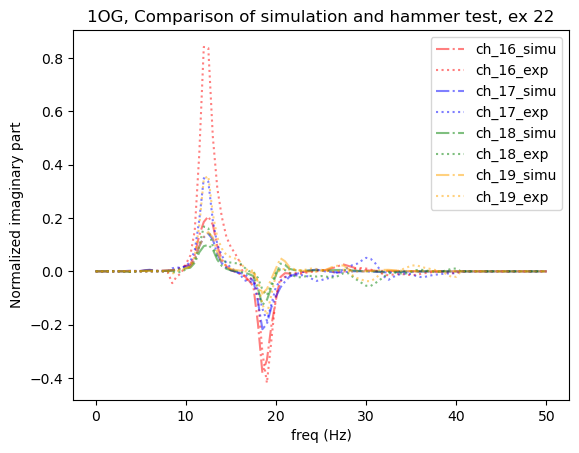

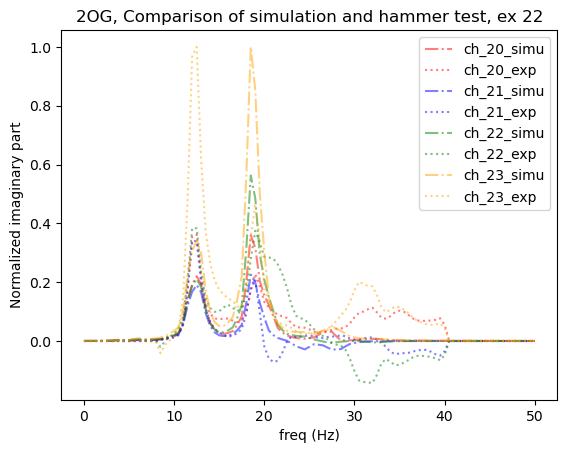

In [5]:
#[0.11781025076362162, -0.25, 1.25, 1.25, 0.49082147361439454, -0.25, 0.314471918168712, -0.25, 1.0761221325446957, -0.25]
X_input =  [0.84507014, 0.11781025076362162        ,-0.25       ,0.50633148 ,0.1885995  ,0.75976072,
                1.25       , 1.25       ,0.21309783 ,0.49082147361439454      ,0.66487426 ,-0.25       ,
                 0.314471918168712       , -0.25       ,1.0761221325446957        ,0.35020139 ,0.35176575 ,0.54754628,
                -0.25       ]
x = [0.84507014, 0.13539517760383665, 1.0, 0.50633148, 0.1885995, 0.75976072, 1.0, 1.0, 0.21309783, 0.5004223475169194, 0.66487426, 0.7993062197679878, 0.6071382305792775, 0.23569906134107818, 0.9707206995435914, 0.35020139, 0.35176575, 0.54754628, 0.0]
objective_function_validation(np.array(X_input ))